# Predict the Probability for the Export output 1 csv file using RNN model

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/5
263/263 [==============================] - 5s 9ms/step - loss: 0.6240 - accuracy: 0.6657 - val_loss: 0.3923 - val_accuracy: 0.8850
Epoch 2/5
263/263 [==============================] - 2s 7ms/step - loss: 0.4377 - accuracy: 0.8063 - val_loss: 0.2654 - val_accuracy: 0.9128
Epoch 3/5
263/263 [==============================] - 2s 7ms/step - loss: 0.3632 - accuracy: 0.8537 - val_loss: 0.2404 - val_accuracy: 0.9194
Epoch 4/5
263/263 [==============================] - 2s 7ms/step - loss: 0.3374 - accuracy: 0.8677 - val_loss: 0.2339 - val_accuracy: 0.9222
Epoch 5/5
57/57 [==============================] - 0s 2ms/step


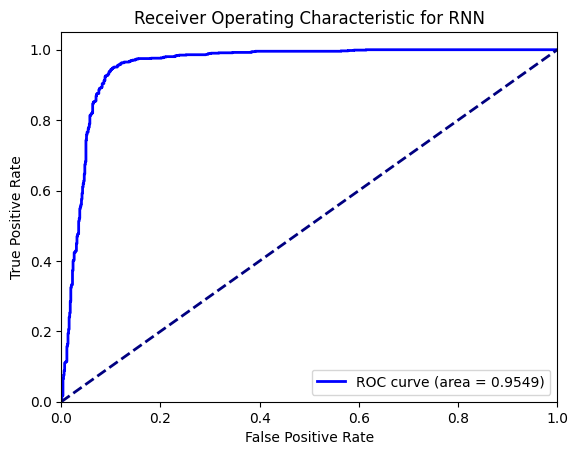

In [ ]:
# Now we should use tained model which is RNN in this case so we have to run the model from the scratch
df = pd.read_csv('DATA.csv', names= ['Wildfire', 'X', 'Y', 'twi', 'aspect', 'temp_july', 'temp_max',
                                       'soilmois', 'slope', 'ndvi', 'lulc', 'dist_lake', 'evt_aug',
                                       'elevation', 'dist_road', 'dist_river', 'pcp', 'index'
                                                   ], header= 0
                      )
df = df.astype(
    {
        'Wildfire': 'category',
        'twi': 'category',
        'aspect': 'category',
        'temp_july': 'category',
        'temp_max': 'category',
        'soilmois': 'category',
        'slope': 'category',
        'ndvi': 'category',
        'lulc': 'category',
        'dist_lake': 'category',
        'evt_aug': 'category',
        'elevation': 'category',
        'dist_road': 'category',
        'dist_river': 'category',
        'pcp': 'category'
    }
)
new_order = [
             'index', 'X', 'Y', 'twi', 'aspect', 'temp_july', 'temp_max', 'soilmois', 'slope', 'ndvi',
             'lulc', 'dist_lake', 'evt_aug', 'elevation', 'dist_road', 'dist_river', 'pcp',  'Wildfire'
            ]
df = df[new_order]
col_to_drop = ['index', 'X', 'Y']
df = df.drop(columns= col_to_drop, axis= 1)
col_to_drop = ['temp_max', 'evt_aug', 'twi']
df = df.drop(columns= col_to_drop, axis= 1)
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

categorical_columns = [
    'aspect', 'temp_july', 'soilmois', 'slope', 'ndvi', 'lulc',
    'dist_lake', 'elevation', 'dist_road', 'dist_river', 'pcp'
]

# Prepare the features and target variable without dropping any columns
X = df.drop(['Wildfire'], axis=1)
y = df['Wildfire']

# Split data into training and remaining sets (temporary set for further split into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42                     )

# Split the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop='first')

# Fit the encoder on training data and transform the training, validation, and test data for categorical columns
encoder.fit(X_train[categorical_columns])
encoded_train = encoder.transform(X_train[categorical_columns])
encoded_val = encoder.transform(X_val[categorical_columns])
encoded_test = encoder.transform(X_test[categorical_columns])

# Convert the encoded features into a DataFrame
encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(categorical_columns))
encoded_val_df = pd.DataFrame(encoded_val, columns=encoder.get_feature_names_out(categorical_columns))
encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the encoded features with the non-categorical data
final_train_df = pd.concat([X_train.drop(categorical_columns, axis=1).reset_index(drop=True), encoded_train_df], axis=1)
final_val_df = pd.concat([X_val.drop(categorical_columns, axis=1).reset_index(drop=True), encoded_val_df], axis=1)
final_test_df = pd.concat([X_test.drop(categorical_columns, axis=1).reset_index(drop=True), encoded_test_df], axis=1)

# Add the target variable 'Wildfire' back to the final datasets
final_train_df['Wildfire'] = y_train.reset_index(drop=True)
final_val_df['Wildfire'] = y_val.reset_index(drop=True)
final_test_df['Wildfire'] = y_test.reset_index(drop=True)
















import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Define the RNN model
def create_rnn_model(input_shape):
    model = Sequential([
        SimpleRNN(8, return_sequences=True, input_shape=input_shape),
        Dropout(0.5),
        SimpleRNN(4, return_sequences=False),  # Only return the final output
        Dropout(0.5),
        Dense(4, activation='relu'),
        Dense(1, activation='sigmoid')  # Use 'sigmoid' for binary classification
    ])
    return model

# Assuming input_shape based on the final_train_df without the target column
input_shape = (1, final_train_df.shape[1] - 1)  # Only one timestep, features equal to number of columns minus target

# Create the model
model = create_rnn_model(input_shape)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Convert target data to float32 to avoid TypeError
y_train = final_train_df['Wildfire'].astype('float32').values
y_val = final_val_df['Wildfire'].astype('float32').values
y_test = final_test_df['Wildfire'].astype('float32').values

# Reshape data to fit the RNN input requirements: [samples, timesteps, features]
X_train = final_train_df.drop('Wildfire', axis=1).values.reshape(-1, 1, final_train_df.shape[1] - 1)
X_val = final_val_df.drop('Wildfire', axis=1).values.reshape(-1, 1, final_val_df.shape[1] - 1)
X_test = final_test_df.drop('Wildfire', axis=1).values.reshape(-1, 1, final_test_df.shape[1] - 1)

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Predict probabilities for ROC curve
y_pred_probs = model.predict(X_test).ravel()

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for RNN')
plt.legend(loc="lower right")
plt.show()


In [ ]:
df1 = pd.read_csv('Export_Output1_with_lat_long.csv', names= ['pointid', 'grid_code', 'aspect', 'temp_july', 'soilmois', 'slope', 'ndvi',
                                      'lulc', 'dist_lake', 'elevation', 'dist_road', 'dist_river', 'pcp',
                                      'Latitude', 'Longitude'
                                                   ], header= 0)

In [ ]:
col_to_drop = ['pointid', 'grid_code']
df1 = df1.drop(columns= col_to_drop, axis= 1)

In [ ]:
df1.head()

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude
0,4,4,4,2,5,4,1,2,1,2,3,45.478238,-80.333373
1,4,4,4,2,5,4,1,2,1,3,3,45.474184,-80.308844
2,4,4,4,2,5,4,1,2,1,3,3,45.470122,-80.284320
3,5,4,4,2,5,4,1,2,0,3,3,45.466055,-80.259800
4,5,4,4,2,5,4,1,2,0,3,3,45.461980,-80.235285


In [ ]:
import pandas as pd
import numpy as np

# Assuming your dataframe is named df1
df1.replace(-9999, np.nan, inplace=True)

# To check if the replacement worked and see the count of null values in each column
null_counts = df1.isnull().sum()
print(null_counts)


aspect          0
temp_july       0
soilmois      509
slope           0
ndvi          514
lulc            0
dist_lake       0
elevation       0
dist_road      76
dist_river     77
pcp           510
Latitude        0
Longitude       0
dtype: int64


In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

# Assuming your dataframe is named df1
# Separate the rows with and without missing values
df_missing = df1[df1.isnull().any(axis=1)]
df_not_missing = df1.dropna()

# Define the features (latitude and longitude) and target
features = ['Latitude', 'Longitude']
target_columns = df1.columns[df1.isnull().any()].tolist()  # Columns with missing values

# For each target column with missing values, we will use KNN to impute the values
for target in target_columns:
    # Prepare the training data
    X_train = df_not_missing[features]
    y_train = df_not_missing[target]

    # Prepare the data to be imputed
    X_missing = df_missing[features]

    # Initialize and fit the KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=3)  # Using 3 nearest neighbors, you can adjust this number
    knn.fit(X_train, y_train)

    # Predict the missing values
    imputed_values = knn.predict(X_missing)

    # Fill the missing values in the original dataframe
    df1.loc[df_missing.index, target] = imputed_values

# Check again for any remaining null values
null_counts_after_imputation = df1.isnull().sum()
print(null_counts_after_imputation)


aspect        0
temp_july     0
soilmois      0
slope         0
ndvi          0
lulc          0
dist_lake     0
elevation     0
dist_road     0
dist_river    0
pcp           0
Latitude      0
Longitude     0
dtype: int64


In [ ]:
df1 = df1.astype(
    {
        'aspect': 'category',
        'temp_july': 'category',
        'soilmois': 'category',
        'slope': 'category',
        'ndvi': 'category',
        'lulc': 'category',
        'dist_lake': 'category',
        'elevation': 'category',
        'dist_road': 'category',
        'dist_river': 'category',
        'pcp': 'category'
    }
)

In [ ]:
df1.head()

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude
0,4,4,4.0,2,5.0,4,1,2,1.0,2.0,3.0,45.478238,-80.333373
1,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.474184,-80.308844
2,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.470122,-80.284320
3,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.466055,-80.259800
4,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.461980,-80.235285


In [ ]:
col_to_drop = ['Latitude', 'Longitude']
df1_new = df1.drop(columns= col_to_drop, axis= 1)

In [ ]:
df1.shape

(1000001, 13)

In [ ]:
df1_new.shape

(1000001, 11)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# Use the trained encoder to transform the categorical data
encoded_data_new = encoder.transform(df1_new[categorical_columns])

# Convert the encoded data to DataFrame
encoded_df_new = pd.DataFrame(encoded_data_new, columns=encoder.get_feature_names_out())

# Concatenate the encoded DataFrame with the non-categorical data
final_df_new = pd.concat([df1_new.drop(categorical_columns, axis=1), encoded_df_new], axis=1)

# Ensure to drop any columns that are not used by the model
# final_df_new.drop(['Latitude', 'Longitude', 'pointid', 'grid_code'], axis=1, inplace=True)

# Reshape data to fit RNN input requirements
X_new = final_df_new.values.reshape(-1, 1, final_df_new.shape[1])

# Load your trained RNN model (if not already loaded)

# Predict using RNN model
predictions = model.predict(X_new)

# Optionally, convert predictions to a DataFrame or other format as needed
predictions_df = pd.DataFrame(predictions, columns=['Wildfire_Probability'])


31251/31251 [==============================] - 70s 2ms/step


In [ ]:
predictions_df.tail(20)

,Wildfire_Probability
999981,0.946037
999982,0.946037
999983,0.949657
999984,0.946927
999985,0.936366
999986,0.948556
999987,0.949152
999988,0.949338
999989,0.947793
999990,0.947793


In [ ]:
# Ensure the predictions DataFrame is properly aligned with the original DataFrame
df1['Wildfire_Probability'] = predictions_df['Wildfire_Probability'].values

In [ ]:
df1.head(10)

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude,Wildfire_Probability
0,4,4,4.0,2,5.0,4,1,2,1.0,2.0,3.0,45.478238,-80.333373,0.054987
1,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.474184,-80.308844,0.054883
2,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.470122,-80.284320,0.054883
3,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.466055,-80.259800,0.074128
4,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.461980,-80.235285,0.074128
5,3,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.457899,-80.210774,0.065594
6,4,4,4.0,3,5.0,4,1,2,0.0,3.0,3.0,45.453812,-80.186268,0.105984
7,4,4,4.0,2,5.0,3,1,2,0.0,2.0,3.0,45.449718,-80.161766,0.023898
8,4,4,4.0,2,5.0,4,1,2,0.0,2.0,3.0,45.445617,-80.137269,0.092537
9,4,4,4.0,3,5.0,4,1,2,0.0,2.0,3.0,45.441510,-80.112776,0.104878


In [ ]:
df1.tail(10)

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude,Wildfire_Probability
999991,5,2,1.0,3,3.0,8,3,3,3.0,4.0,3.0,51.881635,-66.016225,0.931667
999992,5,2,1.0,4,3.0,4,3,3,3.0,4.0,3.0,51.873640,-65.989881,0.948556
999993,5,2,1.0,4,3.0,4,3,3,3.0,4.0,3.0,51.865639,-65.963548,0.948556
999994,5,2,1.0,5,3.0,4,3,3,3.0,4.0,3.0,51.857631,-65.937225,0.946027
999995,4,2,1.0,4,3.0,4,3,3,3.0,4.0,3.0,51.849616,-65.910913,0.949152
999996,3,2,1.0,2,3.0,4,3,3,3.0,4.0,3.0,51.841595,-65.884612,0.948192
999997,3,2,1.0,3,3.0,11,3,3,3.0,4.0,3.0,51.833568,-65.858322,0.939470
999998,5,2,1.0,3,3.0,4,3,3,3.0,4.0,3.0,51.825534,-65.832042,0.949067
999999,4,2,1.0,3,3.0,4,3,3,3.0,4.0,3.0,51.817493,-65.805774,0.949657
1000000,5,2,1.0,2,3.0,4,3,3,3.0,4.0,3.0,51.809446,-65.779515,0.948771


# Predict the Probability for the Export output 2 csv Using RNN model

In [ ]:
df2 = pd.read_csv('Export_Output_2_with_lat_long.csv', names= ['pointid', 'grid_code', 'aspect', 'temp_july', 'soilmois', 'slope', 'ndvi',
                                      'lulc', 'dist_lake', 'elevation', 'dist_road', 'dist_river', 'pcp',
                                      'Latitude', 'Longitude'
                                                   ], header= 0)

In [ ]:
df2.tail()

,pointid,grid_code,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude
1017097,2015,43.0,4,1,1,3,2,5,5,1,4,5,1,69.148333,-138.495084
1017098,2016,27.0,3,1,1,2,2,8,5,1,4,5,1,69.159967,-138.454979
1017099,2017,21.0,3,1,1,2,2,5,5,1,4,5,1,69.171592,-138.414832
1017100,2018,14.0,2,1,1,2,2,3,5,1,4,5,1,69.183207,-138.374644
1017101,2019,14.0,2,1,-9999,2,-9999,3,5,1,4,5,-9999,69.194813,-138.334416


In [ ]:
col_to_drop = ['pointid', 'grid_code']
df2 = df2.drop(columns= col_to_drop, axis= 1)

In [ ]:
df2.head()

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude
0,3,2,1,4,3,4,3,3,3,4,2,51.801392,-65.753268
1,2,2,1,2,3,4,3,3,3,4,3,51.793332,-65.727031
2,3,2,1,4,3,5,3,3,3,4,3,51.785265,-65.700805
3,4,2,1,3,3,5,3,3,3,4,3,51.777192,-65.674590
4,5,2,1,2,3,4,3,3,3,4,3,51.769113,-65.648385


In [ ]:
import pandas as pd
import numpy as np

# Assuming your dataframe is named df1
df2.replace(-9999, np.nan, inplace=True)

# To check if the replacement worked and see the count of null values in each column
null_counts = df2.isnull().sum()
print(null_counts)


aspect          0
temp_july       0
soilmois      879
slope           0
ndvi          859
lulc            0
dist_lake       0
elevation       0
dist_road     124
dist_river    124
pcp           881
Latitude        0
Longitude       0
dtype: int64


In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

# Assuming your dataframe is named df1
# Separate the rows with and without missing values
df_missing = df2[df2.isnull().any(axis=1)]
df_not_missing = df2.dropna()

# Define the features (latitude and longitude) and target
features = ['Latitude', 'Longitude']
target_columns = df2.columns[df2.isnull().any()].tolist()  # Columns with missing values

# For each target column with missing values, we will use KNN to impute the values
for target in target_columns:
    # Prepare the training data
    X_train = df_not_missing[features]
    y_train = df_not_missing[target]

    # Prepare the data to be imputed
    X_missing = df_missing[features]

    # Initialize and fit the KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=3)  # Using 3 nearest neighbors, you can adjust this number
    knn.fit(X_train, y_train)

    # Predict the missing values
    imputed_values = knn.predict(X_missing)

    # Fill the missing values in the original dataframe
    df2.loc[df_missing.index, target] = imputed_values

# Check again for any remaining null values
null_counts_after_imputation = df2.isnull().sum()
print(null_counts_after_imputation)


aspect        0
temp_july     0
soilmois      0
slope         0
ndvi          0
lulc          0
dist_lake     0
elevation     0
dist_road     0
dist_river    0
pcp           0
Latitude      0
Longitude     0
dtype: int64


In [ ]:
df2 = df2.astype(
    {
        'aspect': 'category',
        'temp_july': 'category',
        'soilmois': 'category',
        'slope': 'category',
        'ndvi': 'category',
        'lulc': 'category',
        'dist_lake': 'category',
        'elevation': 'category',
        'dist_road': 'category',
        'dist_river': 'category',
        'pcp': 'category'
    }
)

In [ ]:
df2.head()

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude
0,3,2,1.0,4,3.0,4,3,3,3.0,4.0,2.0,51.801392,-65.753268
1,2,2,1.0,2,3.0,4,3,3,3.0,4.0,3.0,51.793332,-65.727031
2,3,2,1.0,4,3.0,5,3,3,3.0,4.0,3.0,51.785265,-65.700805
3,4,2,1.0,3,3.0,5,3,3,3.0,4.0,3.0,51.777192,-65.674590
4,5,2,1.0,2,3.0,4,3,3,3.0,4.0,3.0,51.769113,-65.648385


In [ ]:
df2.tail()

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude
1017097,4,1,1.0,3,2.0,5,5,1,4.0,5.0,1.0,69.148333,-138.495084
1017098,3,1,1.0,2,2.0,8,5,1,4.0,5.0,1.0,69.159967,-138.454979
1017099,3,1,1.0,2,2.0,5,5,1,4.0,5.0,1.0,69.171592,-138.414832
1017100,2,1,1.0,2,2.0,3,5,1,4.0,5.0,1.0,69.183207,-138.374644
1017101,2,1,1.0,2,2.0,3,5,1,4.0,5.0,1.0,69.194813,-138.334416


In [ ]:
col_to_drop = ['Latitude', 'Longitude']
df2_new = df2.drop(columns= col_to_drop, axis= 1)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# Use the trained encoder to transform the categorical data
encoded_data_new2 = encoder.transform(df2_new[categorical_columns])

# Convert the encoded data to DataFrame
encoded_df_new2 = pd.DataFrame(encoded_data_new2, columns=encoder.get_feature_names_out())

# Concatenate the encoded DataFrame with the non-categorical data
final_df_new2 = pd.concat([df2_new.drop(categorical_columns, axis=1), encoded_df_new2], axis=1)

# Ensure to drop any columns that are not used by the model
# final_df_new.drop(['Latitude', 'Longitude', 'pointid', 'grid_code'], axis=1, inplace=True)

# Reshape data to fit RNN input requirements
X_new2 = final_df_new2.values.reshape(-1, 1, final_df_new2.shape[1])

# Load your trained RNN model (if not already loaded)

# Predict using RNN model
predictions = model.predict(X_new2)

# Optionally, convert predictions to a DataFrame or other format as needed
predictions_df2 = pd.DataFrame(predictions, columns=['Wildfire_Probability'])


31785/31785 [==============================] - 79s 2ms/step


In [ ]:
predictions_df2.tail(20)

,Wildfire_Probability
1017082,0.285587
1017083,0.079359
1017084,0.088844
1017085,0.098138
1017086,0.465996
1017087,0.087870
1017088,0.376080
1017089,0.076448
1017090,0.087870
1017091,0.087870


In [ ]:
# Ensure the predictions DataFrame is properly aligned with the original DataFrame
df2['Wildfire_Probability'] = predictions_df2['Wildfire_Probability'].values

In [ ]:
df2.head()

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude,Wildfire_Probability
0,3,2,1.0,4,3.0,4,3,3,3.0,4.0,2.0,51.801392,-65.753268,0.950250
1,2,2,1.0,2,3.0,4,3,3,3.0,4.0,3.0,51.793332,-65.727031,0.948563
2,3,2,1.0,4,3.0,5,3,3,3.0,4.0,3.0,51.785265,-65.700805,0.941608
3,4,2,1.0,3,3.0,5,3,3,3.0,4.0,3.0,51.777192,-65.674590,0.945923
4,5,2,1.0,2,3.0,4,3,3,3.0,4.0,3.0,51.769113,-65.648385,0.948771


In [ ]:
df1.head()

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude,Wildfire_Probability
0,4,4,4.0,2,5.0,4,1,2,1.0,2.0,3.0,45.478238,-80.333373,0.054987
1,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.474184,-80.308844,0.054883
2,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.470122,-80.284320,0.054883
3,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.466055,-80.259800,0.074128
4,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.461980,-80.235285,0.074128


In [ ]:
col_to_drop = ['aspect', 'temp_july', 'soilmois', 'slope',
               'slope', 'ndvi', 'lulc', 'dist_lake', 'elevation',
               'dist_road', 'dist_river', 'pcp']
df1_final = df1.drop(columns= col_to_drop, axis= 1)

In [ ]:
col_to_drop = ['aspect', 'temp_july', 'soilmois', 'slope',
               'slope', 'ndvi', 'lulc', 'dist_lake', 'elevation',
               'dist_road', 'dist_river', 'pcp']
df2_final = df2.drop(columns= col_to_drop, axis= 1)

In [ ]:
df1_final.tail()

,Latitude,Longitude,Wildfire_Probability
999996,51.841595,-65.884612,0.948192
999997,51.833568,-65.858322,0.939470
999998,51.825534,-65.832042,0.949067
999999,51.817493,-65.805774,0.949657
1000000,51.809446,-65.779515,0.948771


In [ ]:
df2_final.tail()

,Latitude,Longitude,Wildfire_Probability
1017097,69.148333,-138.495084,0.025596
1017098,69.159967,-138.454979,0.019829
1017099,69.171592,-138.414832,0.022695
1017100,69.183207,-138.374644,0.019420
1017101,69.194813,-138.334416,0.019420


In [ ]:
# Add an 'id' column starting from 0 to the length of the DataFrame minus one
df1_final['FID'] = range(0, len(df1_final))
df2_final['FID'] = range(0, len(df2_final))


In [ ]:
df1_final.to_csv('wildfire_probabilities_Export_output1_id.csv', index=False)

In [ ]:
df2_final.to_csv('wildfire_probabilities_Export_output2_id.csv', index=False)

# Predict the Probability for the Export output 1 csv file using BiRNN model

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/5
263/263 [==============================] - 7s 9ms/step - loss: 0.5508 - accuracy: 0.7279 - val_loss: 0.2894 - val_accuracy: 0.9078
Epoch 2/5
263/263 [==============================] - 2s 8ms/step - loss: 0.3522 - accuracy: 0.8690 - val_loss: 0.2356 - val_accuracy: 0.9189
Epoch 3/5
263/263 [==============================] - 3s 12ms/step - loss: 0.3094 - accuracy: 0.8900 - val_loss: 0.2285 - val_accuracy: 0.9250
Epoch 4/5
263/263 [==============================] - 3s 12ms/step - loss: 0.2939 - accuracy: 0.9002 - val_loss: 0.2244 - val_accuracy: 0.9256
Epoch 5/5
57/57 [==============================] - 0s 3ms/step - loss: 0.2288 - accuracy: 0.9261
Test Loss: 0.22880223393440247
Test Accuracy: 0.926111102104187
57/57 [==============================] - 1s 3ms/step


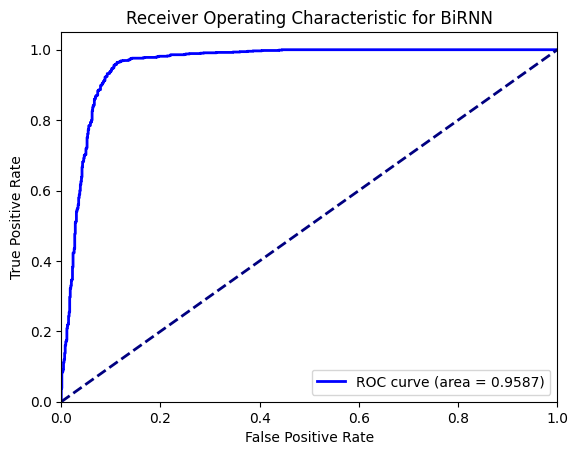

In [ ]:
# Now we should use tained model which is RNN in this case so we have to run the model from the scratch
df = pd.read_csv('DATA.csv', names= ['Wildfire', 'X', 'Y', 'twi', 'aspect', 'temp_july', 'temp_max',
                                       'soilmois', 'slope', 'ndvi', 'lulc', 'dist_lake', 'evt_aug',
                                       'elevation', 'dist_road', 'dist_river', 'pcp', 'index'
                                                   ], header= 0
                      )
df = df.astype(
    {
        'Wildfire': 'category',
        'twi': 'category',
        'aspect': 'category',
        'temp_july': 'category',
        'temp_max': 'category',
        'soilmois': 'category',
        'slope': 'category',
        'ndvi': 'category',
        'lulc': 'category',
        'dist_lake': 'category',
        'evt_aug': 'category',
        'elevation': 'category',
        'dist_road': 'category',
        'dist_river': 'category',
        'pcp': 'category'
    }
)
new_order = [
             'index', 'X', 'Y', 'twi', 'aspect', 'temp_july', 'temp_max', 'soilmois', 'slope', 'ndvi',
             'lulc', 'dist_lake', 'evt_aug', 'elevation', 'dist_road', 'dist_river', 'pcp',  'Wildfire'
            ]
df = df[new_order]
col_to_drop = ['index', 'X', 'Y']
df = df.drop(columns= col_to_drop, axis= 1)
col_to_drop = ['temp_max', 'evt_aug', 'twi']
df = df.drop(columns= col_to_drop, axis= 1)
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

categorical_columns = [
    'aspect', 'temp_july', 'soilmois', 'slope', 'ndvi', 'lulc',
    'dist_lake', 'elevation', 'dist_road', 'dist_river', 'pcp'
]

# Prepare the features and target variable without dropping any columns
X = df.drop(['Wildfire'], axis=1)
y = df['Wildfire']

# Split data into training and remaining sets (temporary set for further split into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42                     )

# Split the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop='first')

# Fit the encoder on training data and transform the training, validation, and test data for categorical columns
encoder.fit(X_train[categorical_columns])
encoded_train = encoder.transform(X_train[categorical_columns])
encoded_val = encoder.transform(X_val[categorical_columns])
encoded_test = encoder.transform(X_test[categorical_columns])

# Convert the encoded features into a DataFrame
encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(categorical_columns))
encoded_val_df = pd.DataFrame(encoded_val, columns=encoder.get_feature_names_out(categorical_columns))
encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the encoded features with the non-categorical data
final_train_df = pd.concat([X_train.drop(categorical_columns, axis=1).reset_index(drop=True), encoded_train_df], axis=1)
final_val_df = pd.concat([X_val.drop(categorical_columns, axis=1).reset_index(drop=True), encoded_val_df], axis=1)
final_test_df = pd.concat([X_test.drop(categorical_columns, axis=1).reset_index(drop=True), encoded_test_df], axis=1)

# Add the target variable 'Wildfire' back to the final datasets
final_train_df['Wildfire'] = y_train.reset_index(drop=True)
final_val_df['Wildfire'] = y_val.reset_index(drop=True)
final_test_df['Wildfire'] = y_test.reset_index(drop=True)






import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Define the BiRNN model
def create_birnn_model(input_shape):
    model = Sequential([
        Bidirectional(SimpleRNN(8, return_sequences=True), input_shape=input_shape),
        Dropout(0.5),
        Bidirectional(SimpleRNN(4, return_sequences=False)),  # Only return the final output
        Dropout(0.5),
        Dense(4, activation='relu'),
        Dense(1, activation='sigmoid')  # Use 'sigmoid' for binary classification
    ])
    return model

# Assuming input_shape based on the final_train_df without the target column
input_shape = (1, final_train_df.shape[1] - 1)  # Only one timestep, features equal to number of columns minus target

# Create the model
model = create_birnn_model(input_shape)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Convert target data to float32 to avoid TypeError
y_train = final_train_df['Wildfire'].astype('float32').values
y_val = final_val_df['Wildfire'].astype('float32').values
y_test = final_test_df['Wildfire'].astype('float32').values

# Reshape data to fit the RNN input requirements: [samples, timesteps, features]
X_train = final_train_df.drop('Wildfire', axis=1).values.reshape(-1, 1, final_train_df.shape[1] - 1)
X_val = final_val_df.drop('Wildfire', axis=1).values.reshape(-1, 1, final_val_df.shape[1] - 1)
X_test = final_test_df.drop('Wildfire', axis=1).values.reshape(-1, 1, final_test_df.shape[1] - 1)

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predict probabilities for ROC curve
y_pred_probs = model.predict(X_test).ravel()

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for BiRNN')
plt.legend(loc="lower right")
plt.show()


In [ ]:
df1 = pd.read_csv('Export_Output1_with_lat_long.csv', names= ['pointid', 'grid_code', 'aspect', 'temp_july', 'soilmois', 'slope', 'ndvi',
                                      'lulc', 'dist_lake', 'elevation', 'dist_road', 'dist_river', 'pcp',
                                      'Latitude', 'Longitude'
                                                   ], header= 0)

In [ ]:
col_to_drop = ['pointid', 'grid_code']
df1 = df1.drop(columns= col_to_drop, axis= 1)

In [ ]:
df1.head()

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude
0,4,4,4,2,5,4,1,2,1,2,3,45.478238,-80.333373
1,4,4,4,2,5,4,1,2,1,3,3,45.474184,-80.308844
2,4,4,4,2,5,4,1,2,1,3,3,45.470122,-80.284320
3,5,4,4,2,5,4,1,2,0,3,3,45.466055,-80.259800
4,5,4,4,2,5,4,1,2,0,3,3,45.461980,-80.235285


In [ ]:
# Assuming your dataframe is named df1
df1.replace(-9999, np.nan, inplace=True)

# To check if the replacement worked and see the count of null values in each column
null_counts = df1.isnull().sum()
print(null_counts)


aspect          0
temp_july       0
soilmois      509
slope           0
ndvi          514
lulc            0
dist_lake       0
elevation       0
dist_road      76
dist_river     77
pcp           510
Latitude        0
Longitude       0
dtype: int64


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Assuming your dataframe is named df1
# Separate the rows with and without missing values
df_missing = df1[df1.isnull().any(axis=1)]
df_not_missing = df1.dropna()

# Define the features (latitude and longitude) and target
features = ['Latitude', 'Longitude']
target_columns = df1.columns[df1.isnull().any()].tolist()  # Columns with missing values

# For each target column with missing values, we will use KNN to impute the values
for target in target_columns:
    # Prepare the training data
    X_train = df_not_missing[features]
    y_train = df_not_missing[target]

    # Prepare the data to be imputed
    X_missing = df_missing[features]

    # Initialize and fit the KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=3)  # Using 3 nearest neighbors, you can adjust this number
    knn.fit(X_train, y_train)

    # Predict the missing values
    imputed_values = knn.predict(X_missing)

    # Fill the missing values in the original dataframe
    df1.loc[df_missing.index, target] = imputed_values

# Check again for any remaining null values
null_counts_after_imputation = df1.isnull().sum()
print(null_counts_after_imputation)


aspect        0
temp_july     0
soilmois      0
slope         0
ndvi          0
lulc          0
dist_lake     0
elevation     0
dist_road     0
dist_river    0
pcp           0
Latitude      0
Longitude     0
dtype: int64


In [ ]:
df1 = df1.astype(
    {
        'aspect': 'category',
        'temp_july': 'category',
        'soilmois': 'category',
        'slope': 'category',
        'ndvi': 'category',
        'lulc': 'category',
        'dist_lake': 'category',
        'elevation': 'category',
        'dist_road': 'category',
        'dist_river': 'category',
        'pcp': 'category'
    }
)

In [ ]:
df1.head()

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude
0,4,4,4.0,2,5.0,4,1,2,1.0,2.0,3.0,45.478238,-80.333373
1,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.474184,-80.308844
2,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.470122,-80.284320
3,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.466055,-80.259800
4,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.461980,-80.235285


In [ ]:
col_to_drop = ['Latitude', 'Longitude']
df1_new = df1.drop(columns= col_to_drop, axis= 1)

In [ ]:
df1.shape

(1000001, 13)

In [ ]:
df1_new.shape

(1000001, 11)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Use the trained encoder to transform the categorical data
encoded_data_new = encoder.transform(df1_new[categorical_columns])

# Convert the encoded data to DataFrame
encoded_df_new = pd.DataFrame(encoded_data_new, columns=encoder.get_feature_names_out())

# Concatenate the encoded DataFrame with the non-categorical data
final_df_new = pd.concat([df1_new.drop(categorical_columns, axis=1), encoded_df_new], axis=1)

# Ensure to drop any columns that are not used by the model
# final_df_new.drop(['Latitude', 'Longitude', 'pointid', 'grid_code'], axis=1, inplace=True)

# Reshape data to fit RNN input requirements
X_new = final_df_new.values.reshape(-1, 1, final_df_new.shape[1])

# Load your trained RNN model (if not already loaded)

# Predict using RNN model
predictions = model.predict(X_new)

# Optionally, convert predictions to a DataFrame or other format as needed
predictions_df = pd.DataFrame(predictions, columns=['WF_BiRNN'])


31251/31251 [==============================] - 101s 3ms/step


In [ ]:
predictions_df.tail(10)

,WF_BiRNN
999991,0.931744
999992,0.943495
999993,0.943495
999994,0.940563
999995,0.941803
999996,0.939229
999997,0.935779
999998,0.943828
999999,0.942290
1000000,0.942134


In [ ]:
# Ensure the predictions DataFrame is properly aligned with the original DataFrame
df1['WF_BiRNN'] = predictions_df['WF_BiRNN'].values

In [ ]:
df1.head(10)

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude,WF_BiRNN
0,4,4,4.0,2,5.0,4,1,2,1.0,2.0,3.0,45.478238,-80.333373,0.037731
1,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.474184,-80.308844,0.036578
2,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.470122,-80.284320,0.036578
3,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.466055,-80.259800,0.036063
4,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.461980,-80.235285,0.036063
5,3,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.457899,-80.210774,0.028309
6,4,4,4.0,3,5.0,4,1,2,0.0,3.0,3.0,45.453812,-80.186268,0.060280
7,4,4,4.0,2,5.0,3,1,2,0.0,2.0,3.0,45.449718,-80.161766,0.017990
8,4,4,4.0,2,5.0,4,1,2,0.0,2.0,3.0,45.445617,-80.137269,0.058541
9,4,4,4.0,3,5.0,4,1,2,0.0,2.0,3.0,45.441510,-80.112776,0.064681


In [ ]:
df1.tail(10)

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude,WF_BiRNN
999991,5,2,1.0,3,3.0,8,3,3,3.0,4.0,3.0,51.881635,-66.016225,0.931744
999992,5,2,1.0,4,3.0,4,3,3,3.0,4.0,3.0,51.873640,-65.989881,0.943495
999993,5,2,1.0,4,3.0,4,3,3,3.0,4.0,3.0,51.865639,-65.963548,0.943495
999994,5,2,1.0,5,3.0,4,3,3,3.0,4.0,3.0,51.857631,-65.937225,0.940563
999995,4,2,1.0,4,3.0,4,3,3,3.0,4.0,3.0,51.849616,-65.910913,0.941803
999996,3,2,1.0,2,3.0,4,3,3,3.0,4.0,3.0,51.841595,-65.884612,0.939229
999997,3,2,1.0,3,3.0,11,3,3,3.0,4.0,3.0,51.833568,-65.858322,0.935779
999998,5,2,1.0,3,3.0,4,3,3,3.0,4.0,3.0,51.825534,-65.832042,0.943828
999999,4,2,1.0,3,3.0,4,3,3,3.0,4.0,3.0,51.817493,-65.805774,0.942290
1000000,5,2,1.0,2,3.0,4,3,3,3.0,4.0,3.0,51.809446,-65.779515,0.942134


# Predict the Probability for the Export output 2 csv Using BiRNN model

In [ ]:
df2 = pd.read_csv('Export_Output_2_with_lat_long.csv', names= ['pointid', 'grid_code', 'aspect', 'temp_july', 'soilmois', 'slope', 'ndvi',
                                      'lulc', 'dist_lake', 'elevation', 'dist_road', 'dist_river', 'pcp',
                                      'Latitude', 'Longitude'
                                                   ], header= 0)

In [ ]:
col_to_drop = ['pointid', 'grid_code']
df2 = df2.drop(columns= col_to_drop, axis= 1)

In [ ]:
# Assuming your dataframe is named df1
df2.replace(-9999, np.nan, inplace=True)

# To check if the replacement worked and see the count of null values in each column
null_counts = df2.isnull().sum()
print(null_counts)


aspect          0
temp_july       0
soilmois      879
slope           0
ndvi          859
lulc            0
dist_lake       0
elevation       0
dist_road     124
dist_river    124
pcp           881
Latitude        0
Longitude       0
dtype: int64


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Assuming your dataframe is named df1
# Separate the rows with and without missing values
df_missing = df2[df2.isnull().any(axis=1)]
df_not_missing = df2.dropna()

# Define the features (latitude and longitude) and target
features = ['Latitude', 'Longitude']
target_columns = df2.columns[df2.isnull().any()].tolist()  # Columns with missing values

# For each target column with missing values, we will use KNN to impute the values
for target in target_columns:
    # Prepare the training data
    X_train = df_not_missing[features]
    y_train = df_not_missing[target]

    # Prepare the data to be imputed
    X_missing = df_missing[features]

    # Initialize and fit the KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=3)  # Using 3 nearest neighbors, you can adjust this number
    knn.fit(X_train, y_train)

    # Predict the missing values
    imputed_values = knn.predict(X_missing)

    # Fill the missing values in the original dataframe
    df2.loc[df_missing.index, target] = imputed_values

# Check again for any remaining null values
null_counts_after_imputation = df2.isnull().sum()
print(null_counts_after_imputation)


aspect        0
temp_july     0
soilmois      0
slope         0
ndvi          0
lulc          0
dist_lake     0
elevation     0
dist_road     0
dist_river    0
pcp           0
Latitude      0
Longitude     0
dtype: int64


In [ ]:
df2 = df2.astype(
    {
        'aspect': 'category',
        'temp_july': 'category',
        'soilmois': 'category',
        'slope': 'category',
        'ndvi': 'category',
        'lulc': 'category',
        'dist_lake': 'category',
        'elevation': 'category',
        'dist_road': 'category',
        'dist_river': 'category',
        'pcp': 'category'
    }
)

In [ ]:
col_to_drop = ['Latitude', 'Longitude']
df2_new = df2.drop(columns= col_to_drop, axis= 1)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Use the trained encoder to transform the categorical data
encoded_data_new2 = encoder.transform(df2_new[categorical_columns])

# Convert the encoded data to DataFrame
encoded_df_new2 = pd.DataFrame(encoded_data_new2, columns=encoder.get_feature_names_out())

# Concatenate the encoded DataFrame with the non-categorical data
final_df_new2 = pd.concat([df2_new.drop(categorical_columns, axis=1), encoded_df_new2], axis=1)

# Ensure to drop any columns that are not used by the model
# final_df_new.drop(['Latitude', 'Longitude', 'pointid', 'grid_code'], axis=1, inplace=True)

# Reshape data to fit RNN input requirements
X_new2 = final_df_new2.values.reshape(-1, 1, final_df_new2.shape[1])

# Load your trained RNN model (if not already loaded)

# Predict using RNN model
predictions = model.predict(X_new2)

# Optionally, convert predictions to a DataFrame or other format as needed
predictions_df2 = pd.DataFrame(predictions, columns=['WF_BiRNN'])


31785/31785 [==============================] - 103s 3ms/step


In [ ]:
predictions_df2.tail(10)

,WF_BiRNN
1017092,0.014597
1017093,0.014948
1017094,0.016213
1017095,0.011940
1017096,0.013874
1017097,0.012545
1017098,0.011825
1017099,0.012215
1017100,0.011366
1017101,0.011366


In [ ]:
# Ensure the predictions DataFrame is properly aligned with the original DataFrame
df2['WF_BiRNN'] = predictions_df2['WF_BiRNN'].values

In [ ]:
df1.head()

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude,WF_BiRNN
0,4,4,4.0,2,5.0,4,1,2,1.0,2.0,3.0,45.478238,-80.333373,0.037731
1,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.474184,-80.308844,0.036578
2,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.470122,-80.284320,0.036578
3,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.466055,-80.259800,0.036063
4,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.461980,-80.235285,0.036063


In [ ]:
df2.head()

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude,WF_BiRNN
0,3,2,1.0,4,3.0,4,3,3,3.0,4.0,2.0,51.801392,-65.753268,0.942392
1,2,2,1.0,2,3.0,4,3,3,3.0,4.0,3.0,51.793332,-65.727031,0.941986
2,3,2,1.0,4,3.0,5,3,3,3.0,4.0,3.0,51.785265,-65.700805,0.935419
3,4,2,1.0,3,3.0,5,3,3,3.0,4.0,3.0,51.777192,-65.674590,0.939735
4,5,2,1.0,2,3.0,4,3,3,3.0,4.0,3.0,51.769113,-65.648385,0.942134


In [ ]:
col_to_drop = ['aspect', 'temp_july', 'soilmois', 'slope',
               'slope', 'ndvi', 'lulc', 'dist_lake', 'elevation',
               'dist_road', 'dist_river', 'pcp', 'Latitude', 'Longitude']
df1_final = df1.drop(columns= col_to_drop, axis= 1)

In [ ]:
col_to_drop = ['aspect', 'temp_july', 'soilmois', 'slope',
               'slope', 'ndvi', 'lulc', 'dist_lake', 'elevation',
               'dist_road', 'dist_river', 'pcp', 'Latitude', 'Longitude']
df2_final = df2.drop(columns= col_to_drop, axis= 1)

In [ ]:
# Add an 'id' column starting from 0 to the length of the DataFrame minus one
df1_final['FID'] = range(0, len(df1_final))
df2_final['FID'] = range(0, len(df2_final))

In [ ]:
df1_final.to_csv('WF_BiRNN_Export_output1_id.csv', index=False)

In [ ]:
df2_final.to_csv('WF_BiRNN_Export_output2_id.csv', index=False)

# Predict the Probability for the Export output 1 csv Using LSTM model

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/5
263/263 [==============================] - 9s 10ms/step - loss: 0.6616 - accuracy: 0.6396 - val_loss: 0.5234 - val_accuracy: 0.8761
Epoch 2/5
263/263 [==============================] - 1s 5ms/step - loss: 0.4588 - accuracy: 0.8390 - val_loss: 0.2809 - val_accuracy: 0.9167
Epoch 3/5
263/263 [==============================] - 1s 5ms/step - loss: 0.3676 - accuracy: 0.8585 - val_loss: 0.2469 - val_accuracy: 0.9222
Epoch 4/5
263/263 [==============================] - 1s 5ms/step - loss: 0.3405 - accuracy: 0.8789 - val_loss: 0.2326 - val_accuracy: 0.9239
Epoch 5/5
57/57 [==============================] - 1s 2ms/step


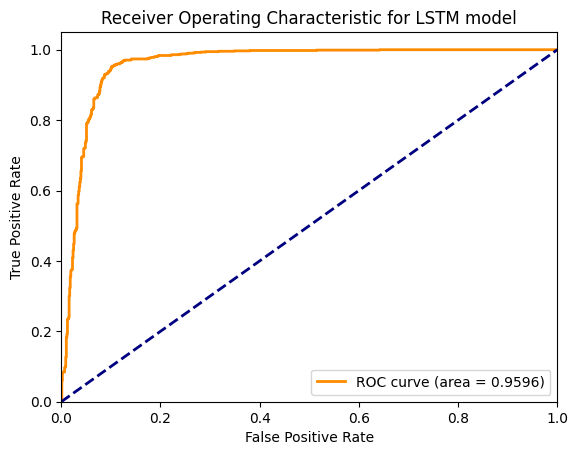

In [ ]:
# Now we should use tained model which is RNN in this case so we have to run the model from the scratch
df = pd.read_csv('DATA.csv', names= ['Wildfire', 'X', 'Y', 'twi', 'aspect', 'temp_july', 'temp_max',
                                       'soilmois', 'slope', 'ndvi', 'lulc', 'dist_lake', 'evt_aug',
                                       'elevation', 'dist_road', 'dist_river', 'pcp', 'index'
                                                   ], header= 0
                      )
df = df.astype(
    {
        'Wildfire': 'category',
        'twi': 'category',
        'aspect': 'category',
        'temp_july': 'category',
        'temp_max': 'category',
        'soilmois': 'category',
        'slope': 'category',
        'ndvi': 'category',
        'lulc': 'category',
        'dist_lake': 'category',
        'evt_aug': 'category',
        'elevation': 'category',
        'dist_road': 'category',
        'dist_river': 'category',
        'pcp': 'category'
    }
)
new_order = [
             'index', 'X', 'Y', 'twi', 'aspect', 'temp_july', 'temp_max', 'soilmois', 'slope', 'ndvi',
             'lulc', 'dist_lake', 'evt_aug', 'elevation', 'dist_road', 'dist_river', 'pcp',  'Wildfire'
            ]
df = df[new_order]
col_to_drop = ['index', 'X', 'Y']
df = df.drop(columns= col_to_drop, axis= 1)
col_to_drop = ['temp_max', 'evt_aug', 'twi']
df = df.drop(columns= col_to_drop, axis= 1)
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

categorical_columns = [
    'aspect', 'temp_july', 'soilmois', 'slope', 'ndvi', 'lulc',
    'dist_lake', 'elevation', 'dist_road', 'dist_river', 'pcp'
]

# Prepare the features and target variable without dropping any columns
X = df.drop(['Wildfire'], axis=1)
y = df['Wildfire']

# Split data into training and remaining sets (temporary set for further split into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42                     )

# Split the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop='first')

# Fit the encoder on training data and transform the training, validation, and test data for categorical columns
encoder.fit(X_train[categorical_columns])
encoded_train = encoder.transform(X_train[categorical_columns])
encoded_val = encoder.transform(X_val[categorical_columns])
encoded_test = encoder.transform(X_test[categorical_columns])

# Convert the encoded features into a DataFrame
encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(categorical_columns))
encoded_val_df = pd.DataFrame(encoded_val, columns=encoder.get_feature_names_out(categorical_columns))
encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the encoded features with the non-categorical data
final_train_df = pd.concat([X_train.drop(categorical_columns, axis=1).reset_index(drop=True), encoded_train_df], axis=1)
final_val_df = pd.concat([X_val.drop(categorical_columns, axis=1).reset_index(drop=True), encoded_val_df], axis=1)
final_test_df = pd.concat([X_test.drop(categorical_columns, axis=1).reset_index(drop=True), encoded_test_df], axis=1)

# Add the target variable 'Wildfire' back to the final datasets
final_train_df['Wildfire'] = y_train.reset_index(drop=True)
final_val_df['Wildfire'] = y_val.reset_index(drop=True)
final_test_df['Wildfire'] = y_test.reset_index(drop=True)








import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Define the LSTM model
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(8, return_sequences=True, input_shape=input_shape),
        Dropout(0.5),
        LSTM(4, return_sequences=False),  # Remove return_sequences if you only want the last output
        Dropout(0.5),
        Dense(4, activation='relu'),
        Dense(1, activation='sigmoid')  # Use 'sigmoid' for binary classification
    ])
    return model

# Assuming input_shape based on the final_train_df without the target column
input_shape = (1, final_train_df.shape[1] - 1)  # Only one timestep, features equal to number of columns minus target

# Create the model
model = create_lstm_model(input_shape)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Convert target data to float32 to avoid TypeError
y_train = final_train_df['Wildfire'].astype('float32').values
y_val = final_val_df['Wildfire'].astype('float32').values
y_test = final_test_df['Wildfire'].astype('float32').values

# Reshape data to fit the LSTM input requirements: [samples, timesteps, features]
X_train = final_train_df.drop('Wildfire', axis=1).values.reshape(-1, 1, final_train_df.shape[1] - 1)
X_val = final_val_df.drop('Wildfire', axis=1).values.reshape(-1, 1, final_val_df.shape[1] - 1)
X_test = final_test_df.drop('Wildfire', axis=1).values.reshape(-1, 1, final_test_df.shape[1] - 1)

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Predict probabilities for ROC curve
y_pred_probs = model.predict(X_test).ravel()

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for LSTM model')
plt.legend(loc="lower right")
plt.show()


In [ ]:
df1 = pd.read_csv('Export_Output1_with_lat_long.csv', names= ['pointid', 'grid_code', 'aspect', 'temp_july', 'soilmois', 'slope', 'ndvi',
                                      'lulc', 'dist_lake', 'elevation', 'dist_road', 'dist_river', 'pcp',
                                      'Latitude', 'Longitude'
                                                   ], header= 0)

In [ ]:
col_to_drop = ['pointid', 'grid_code']
df1 = df1.drop(columns= col_to_drop, axis= 1)

In [ ]:
df1.head()

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude
0,4,4,4,2,5,4,1,2,1,2,3,45.478238,-80.333373
1,4,4,4,2,5,4,1,2,1,3,3,45.474184,-80.308844
2,4,4,4,2,5,4,1,2,1,3,3,45.470122,-80.284320
3,5,4,4,2,5,4,1,2,0,3,3,45.466055,-80.259800
4,5,4,4,2,5,4,1,2,0,3,3,45.461980,-80.235285


In [ ]:
# Assuming your dataframe is named df1
df1.replace(-9999, np.nan, inplace=True)

# To check if the replacement worked and see the count of null values in each column
null_counts = df1.isnull().sum()
print(null_counts)


aspect          0
temp_july       0
soilmois      509
slope           0
ndvi          514
lulc            0
dist_lake       0
elevation       0
dist_road      76
dist_river     77
pcp           510
Latitude        0
Longitude       0
dtype: int64


In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

# Assuming your dataframe is named df1
# Separate the rows with and without missing values
df_missing = df1[df1.isnull().any(axis=1)]
df_not_missing = df1.dropna()

# Define the features (latitude and longitude) and target
features = ['Latitude', 'Longitude']
target_columns = df1.columns[df1.isnull().any()].tolist()  # Columns with missing values

# For each target column with missing values, we will use KNN to impute the values
for target in target_columns:
    # Prepare the training data
    X_train = df_not_missing[features]
    y_train = df_not_missing[target]

    # Prepare the data to be imputed
    X_missing = df_missing[features]

    # Initialize and fit the KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=3)  # Using 3 nearest neighbors, you can adjust this number
    knn.fit(X_train, y_train)

    # Predict the missing values
    imputed_values = knn.predict(X_missing)

    # Fill the missing values in the original dataframe
    df1.loc[df_missing.index, target] = imputed_values

# Check again for any remaining null values
null_counts_after_imputation = df1.isnull().sum()
print(null_counts_after_imputation)


aspect        0
temp_july     0
soilmois      0
slope         0
ndvi          0
lulc          0
dist_lake     0
elevation     0
dist_road     0
dist_river    0
pcp           0
Latitude      0
Longitude     0
dtype: int64


In [ ]:
df1 = df1.astype(
    {
        'aspect': 'category',
        'temp_july': 'category',
        'soilmois': 'category',
        'slope': 'category',
        'ndvi': 'category',
        'lulc': 'category',
        'dist_lake': 'category',
        'elevation': 'category',
        'dist_road': 'category',
        'dist_river': 'category',
        'pcp': 'category'
    }
)

In [ ]:
df1.head()

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude
0,4,4,4.0,2,5.0,4,1,2,1.0,2.0,3.0,45.478238,-80.333373
1,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.474184,-80.308844
2,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.470122,-80.284320
3,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.466055,-80.259800
4,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.461980,-80.235285


In [ ]:
col_to_drop = ['Latitude', 'Longitude']
df1_new = df1.drop(columns= col_to_drop, axis= 1)

In [ ]:
df1.shape

(1000001, 13)

In [ ]:
df1_new.shape

(1000001, 11)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# Use the trained encoder to transform the categorical data
encoded_data_new = encoder.transform(df1_new[categorical_columns])

# Convert the encoded data to DataFrame
encoded_df_new = pd.DataFrame(encoded_data_new, columns=encoder.get_feature_names_out())

# Concatenate the encoded DataFrame with the non-categorical data
final_df_new = pd.concat([df1_new.drop(categorical_columns, axis=1), encoded_df_new], axis=1)

# Ensure to drop any columns that are not used by the model
# final_df_new.drop(['Latitude', 'Longitude', 'pointid', 'grid_code'], axis=1, inplace=True)

# Reshape data to fit RNN input requirements
X_new = final_df_new.values.reshape(-1, 1, final_df_new.shape[1])

# Load your trained RNN model (if not already loaded)

# Predict using RNN model
predictions = model.predict(X_new)

# Optionally, convert predictions to a DataFrame or other format as needed
predictions_df = pd.DataFrame(predictions, columns=['WF_LSTM']).round(3)

# Display the last 10 entries
predictions_df.tail(10)


31251/31251 [==============================] - 74s 2ms/step


,WF_LSTM
999991,0.927
999992,0.948
999993,0.948
999994,0.938
999995,0.952
999996,0.949
999997,0.938
999998,0.947
999999,0.951
1000000,0.947


In [ ]:
# Ensure the predictions DataFrame is properly aligned with the original DataFrame
df1['WF_LSTM'] = predictions_df['WF_LSTM'].values

In [ ]:
df1.head(10)

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude,WF_LSTM
0,4,4,4.0,2,5.0,4,1,2,1.0,2.0,3.0,45.478238,-80.333373,0.092
1,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.474184,-80.308844,0.086
2,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.470122,-80.284320,0.086
3,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.466055,-80.259800,0.083
4,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.461980,-80.235285,0.083
5,3,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.457899,-80.210774,0.080
6,4,4,4.0,3,5.0,4,1,2,0.0,3.0,3.0,45.453812,-80.186268,0.103
7,4,4,4.0,2,5.0,3,1,2,0.0,2.0,3.0,45.449718,-80.161766,0.059
8,4,4,4.0,2,5.0,4,1,2,0.0,2.0,3.0,45.445617,-80.137269,0.116
9,4,4,4.0,3,5.0,4,1,2,0.0,2.0,3.0,45.441510,-80.112776,0.113


In [ ]:
df1.tail(10)

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude,WF_LSTM
999991,5,2,1.0,3,3.0,8,3,3,3.0,4.0,3.0,51.881635,-66.016225,0.927
999992,5,2,1.0,4,3.0,4,3,3,3.0,4.0,3.0,51.873640,-65.989881,0.948
999993,5,2,1.0,4,3.0,4,3,3,3.0,4.0,3.0,51.865639,-65.963548,0.948
999994,5,2,1.0,5,3.0,4,3,3,3.0,4.0,3.0,51.857631,-65.937225,0.938
999995,4,2,1.0,4,3.0,4,3,3,3.0,4.0,3.0,51.849616,-65.910913,0.952
999996,3,2,1.0,2,3.0,4,3,3,3.0,4.0,3.0,51.841595,-65.884612,0.949
999997,3,2,1.0,3,3.0,11,3,3,3.0,4.0,3.0,51.833568,-65.858322,0.938
999998,5,2,1.0,3,3.0,4,3,3,3.0,4.0,3.0,51.825534,-65.832042,0.947
999999,4,2,1.0,3,3.0,4,3,3,3.0,4.0,3.0,51.817493,-65.805774,0.951
1000000,5,2,1.0,2,3.0,4,3,3,3.0,4.0,3.0,51.809446,-65.779515,0.947


# Predict the Probability for the Export output 2 csv Using LSTM model

In [ ]:
df2 = pd.read_csv('Export_Output_2_with_lat_long.csv', names= ['pointid', 'grid_code', 'aspect', 'temp_july', 'soilmois', 'slope', 'ndvi',
                                      'lulc', 'dist_lake', 'elevation', 'dist_road', 'dist_river', 'pcp',
                                      'Latitude', 'Longitude'
                                                   ], header= 0)

In [ ]:
df2.tail()

,pointid,grid_code,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude
1017097,2015,43.0,4,1,1,3,2,5,5,1,4,5,1,69.148333,-138.495084
1017098,2016,27.0,3,1,1,2,2,8,5,1,4,5,1,69.159967,-138.454979
1017099,2017,21.0,3,1,1,2,2,5,5,1,4,5,1,69.171592,-138.414832
1017100,2018,14.0,2,1,1,2,2,3,5,1,4,5,1,69.183207,-138.374644
1017101,2019,14.0,2,1,-9999,2,-9999,3,5,1,4,5,-9999,69.194813,-138.334416


In [ ]:
col_to_drop = ['pointid', 'grid_code']
df2 = df2.drop(columns= col_to_drop, axis= 1)

In [ ]:
df2.head()

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude
0,3,2,1,4,3,4,3,3,3,4,2,51.801392,-65.753268
1,2,2,1,2,3,4,3,3,3,4,3,51.793332,-65.727031
2,3,2,1,4,3,5,3,3,3,4,3,51.785265,-65.700805
3,4,2,1,3,3,5,3,3,3,4,3,51.777192,-65.674590
4,5,2,1,2,3,4,3,3,3,4,3,51.769113,-65.648385


In [ ]:
# Assuming your dataframe is named df1
df2.replace(-9999, np.nan, inplace=True)

# To check if the replacement worked and see the count of null values in each column
null_counts = df2.isnull().sum()
print(null_counts)


aspect          0
temp_july       0
soilmois      879
slope           0
ndvi          859
lulc            0
dist_lake       0
elevation       0
dist_road     124
dist_river    124
pcp           881
Latitude        0
Longitude       0
dtype: int64


In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

# Assuming your dataframe is named df1
# Separate the rows with and without missing values
df_missing = df2[df2.isnull().any(axis=1)]
df_not_missing = df2.dropna()

# Define the features (latitude and longitude) and target
features = ['Latitude', 'Longitude']
target_columns = df2.columns[df2.isnull().any()].tolist()  # Columns with missing values

# For each target column with missing values, we will use KNN to impute the values
for target in target_columns:
    # Prepare the training data
    X_train = df_not_missing[features]
    y_train = df_not_missing[target]

    # Prepare the data to be imputed
    X_missing = df_missing[features]

    # Initialize and fit the KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=3)  # Using 3 nearest neighbors, you can adjust this number
    knn.fit(X_train, y_train)

    # Predict the missing values
    imputed_values = knn.predict(X_missing)

    # Fill the missing values in the original dataframe
    df2.loc[df_missing.index, target] = imputed_values

# Check again for any remaining null values
null_counts_after_imputation = df2.isnull().sum()
print(null_counts_after_imputation)


aspect        0
temp_july     0
soilmois      0
slope         0
ndvi          0
lulc          0
dist_lake     0
elevation     0
dist_road     0
dist_river    0
pcp           0
Latitude      0
Longitude     0
dtype: int64


In [ ]:
df2 = df2.astype(
    {
        'aspect': 'category',
        'temp_july': 'category',
        'soilmois': 'category',
        'slope': 'category',
        'ndvi': 'category',
        'lulc': 'category',
        'dist_lake': 'category',
        'elevation': 'category',
        'dist_road': 'category',
        'dist_river': 'category',
        'pcp': 'category'
    }
)

In [ ]:
df2.head()

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude
0,3,2,1.0,4,3.0,4,3,3,3.0,4.0,2.0,51.801392,-65.753268
1,2,2,1.0,2,3.0,4,3,3,3.0,4.0,3.0,51.793332,-65.727031
2,3,2,1.0,4,3.0,5,3,3,3.0,4.0,3.0,51.785265,-65.700805
3,4,2,1.0,3,3.0,5,3,3,3.0,4.0,3.0,51.777192,-65.674590
4,5,2,1.0,2,3.0,4,3,3,3.0,4.0,3.0,51.769113,-65.648385


In [ ]:
df2.tail()

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude
1017097,4,1,1.0,3,2.0,5,5,1,4.0,5.0,1.0,69.148333,-138.495084
1017098,3,1,1.0,2,2.0,8,5,1,4.0,5.0,1.0,69.159967,-138.454979
1017099,3,1,1.0,2,2.0,5,5,1,4.0,5.0,1.0,69.171592,-138.414832
1017100,2,1,1.0,2,2.0,3,5,1,4.0,5.0,1.0,69.183207,-138.374644
1017101,2,1,1.0,2,2.0,3,5,1,4.0,5.0,1.0,69.194813,-138.334416


In [ ]:
col_to_drop = ['Latitude', 'Longitude']
df2_new = df2.drop(columns= col_to_drop, axis= 1)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# Use the trained encoder to transform the categorical data
encoded_data_new2 = encoder.transform(df2_new[categorical_columns])

# Convert the encoded data to DataFrame
encoded_df_new2 = pd.DataFrame(encoded_data_new2, columns=encoder.get_feature_names_out())

# Concatenate the encoded DataFrame with the non-categorical data
final_df_new2 = pd.concat([df2_new.drop(categorical_columns, axis=1), encoded_df_new2], axis=1)

# Ensure to drop any columns that are not used by the model
# final_df_new.drop(['Latitude', 'Longitude', 'pointid', 'grid_code'], axis=1, inplace=True)

# Reshape data to fit RNN input requirements
X_new2 = final_df_new2.values.reshape(-1, 1, final_df_new2.shape[1])

# Load your trained RNN model (if not already loaded)

# Predict using RNN model
predictions = model.predict(X_new2)

# Optionally, convert predictions to a DataFrame or other format as needed
predictions_df2 = pd.DataFrame(predictions, columns=['WF_LSTM'])

# Round the predictions to 2 decimal places
predictions_df2['WF_LSTM'] = predictions_df2['WF_LSTM'].round(3)

# Display the last 10 entries
predictions_df2.tail(10)


31785/31785 [==============================] - 74s 2ms/step


,WF_LSTM
1017092,0.043
1017093,0.043
1017094,0.037
1017095,0.035
1017096,0.036
1017097,0.034
1017098,0.032
1017099,0.033
1017100,0.035
1017101,0.035


In [ ]:
predictions_df2.tail(10)

,WF_LSTM
1017092,0.043
1017093,0.043
1017094,0.037
1017095,0.035
1017096,0.036
1017097,0.034
1017098,0.032
1017099,0.033
1017100,0.035
1017101,0.035


In [ ]:
# Ensure the predictions DataFrame is properly aligned with the original DataFrame
df2['WF_LSTM'] = predictions_df2['WF_LSTM'].values

In [ ]:
df2.head()

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude,WF_LSTM
0,3,2,1.0,4,3.0,4,3,3,3.0,4.0,2.0,51.801392,-65.753268,0.952
1,2,2,1.0,2,3.0,4,3,3,3.0,4.0,3.0,51.793332,-65.727031,0.946
2,3,2,1.0,4,3.0,5,3,3,3.0,4.0,3.0,51.785265,-65.700805,0.940
3,4,2,1.0,3,3.0,5,3,3,3.0,4.0,3.0,51.777192,-65.674590,0.943
4,5,2,1.0,2,3.0,4,3,3,3.0,4.0,3.0,51.769113,-65.648385,0.947


In [ ]:
df1.head()

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude,WF_LSTM
0,4,4,4.0,2,5.0,4,1,2,1.0,2.0,3.0,45.478238,-80.333373,0.092
1,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.474184,-80.308844,0.086
2,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.470122,-80.284320,0.086
3,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.466055,-80.259800,0.083
4,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.461980,-80.235285,0.083


In [ ]:
col_to_drop = ['aspect', 'temp_july', 'soilmois', 'slope',
               'slope', 'ndvi', 'lulc', 'dist_lake', 'elevation',
               'dist_road', 'dist_river', 'pcp']
df1_final = df1.drop(columns= col_to_drop, axis= 1)

In [ ]:
col_to_drop = ['aspect', 'temp_july', 'soilmois', 'slope',
               'slope', 'ndvi', 'lulc', 'dist_lake', 'elevation',
               'dist_road', 'dist_river', 'pcp']
df2_final = df2.drop(columns= col_to_drop, axis= 1)

In [ ]:
df1_final.tail()

,Latitude,Longitude,WF_LSTM
999996,51.841595,-65.884612,0.949
999997,51.833568,-65.858322,0.938
999998,51.825534,-65.832042,0.947
999999,51.817493,-65.805774,0.951
1000000,51.809446,-65.779515,0.947


In [ ]:
df2_final.tail()

,Latitude,Longitude,WF_LSTM
1017097,69.148333,-138.495084,0.034
1017098,69.159967,-138.454979,0.032
1017099,69.171592,-138.414832,0.033
1017100,69.183207,-138.374644,0.035
1017101,69.194813,-138.334416,0.035


In [ ]:
# Add an 'id' column starting from 0 to the length of the DataFrame minus one
df1_final['FID'] = range(0, len(df1_final))
df2_final['FID'] = range(0, len(df2_final))


In [ ]:
df1_final.to_csv('WF_Export1_LSTM.csv', index=False)

In [ ]:
df2_final.to_csv('WF_Export2_LSTM.csv', index=False)

# Predict the Probability for the Export output 1 csv file using BiLSTM model

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/5
263/263 [==============================] - 17s 12ms/step - loss: 0.6209 - accuracy: 0.6767 - val_loss: 0.4665 - val_accuracy: 0.9056
Epoch 2/5
263/263 [==============================] - 2s 6ms/step - loss: 0.4681 - accuracy: 0.8889 - val_loss: 0.3982 - val_accuracy: 0.9172
Epoch 3/5
263/263 [==============================] - 2s 6ms/step - loss: 0.4170 - accuracy: 0.9058 - val_loss: 0.3628 - val_accuracy: 0.9194
Epoch 4/5
263/263 [==============================] - 2s 6ms/step - loss: 0.3820 - accuracy: 0.9033 - val_loss: 0.3339 - val_accuracy: 0.9228
Epoch 5/5
57/57 [==============================] - 2s 2ms/step


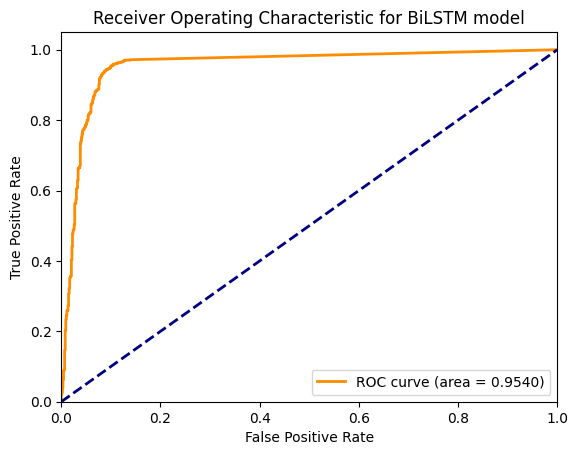

In [ ]:
df = pd.read_csv('DATA.csv', names= ['Wildfire', 'X', 'Y', 'twi', 'aspect', 'temp_july', 'temp_max',
                                       'soilmois', 'slope', 'ndvi', 'lulc', 'dist_lake', 'evt_aug',
                                       'elevation', 'dist_road', 'dist_river', 'pcp', 'index'
                                                   ], header= 0
                      )
df = df.astype(
    {
        'Wildfire': 'category',
        'twi': 'category',
        'aspect': 'category',
        'temp_july': 'category',
        'temp_max': 'category',
        'soilmois': 'category',
        'slope': 'category',
        'ndvi': 'category',
        'lulc': 'category',
        'dist_lake': 'category',
        'evt_aug': 'category',
        'elevation': 'category',
        'dist_road': 'category',
        'dist_river': 'category',
        'pcp': 'category'
    }
)
new_order = [
             'index', 'X', 'Y', 'twi', 'aspect', 'temp_july', 'temp_max', 'soilmois', 'slope', 'ndvi',
             'lulc', 'dist_lake', 'evt_aug', 'elevation', 'dist_road', 'dist_river', 'pcp',  'Wildfire'
            ]
df = df[new_order]
col_to_drop = ['index', 'X', 'Y']
df = df.drop(columns= col_to_drop, axis= 1)
col_to_drop = ['temp_max', 'evt_aug', 'twi']
df = df.drop(columns= col_to_drop, axis= 1)
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

categorical_columns = [
    'aspect', 'temp_july', 'soilmois', 'slope', 'ndvi', 'lulc',
    'dist_lake', 'elevation', 'dist_road', 'dist_river', 'pcp'
]

# Prepare the features and target variable without dropping any columns
X = df.drop(['Wildfire'], axis=1)
y = df['Wildfire']

# Split data into training and remaining sets (temporary set for further split into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42                     )

# Split the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop='first')

# Fit the encoder on training data and transform the training, validation, and test data for categorical columns
encoder.fit(X_train[categorical_columns])
encoded_train = encoder.transform(X_train[categorical_columns])
encoded_val = encoder.transform(X_val[categorical_columns])
encoded_test = encoder.transform(X_test[categorical_columns])

# Convert the encoded features into a DataFrame
encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(categorical_columns))
encoded_val_df = pd.DataFrame(encoded_val, columns=encoder.get_feature_names_out(categorical_columns))
encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the encoded features with the non-categorical data
final_train_df = pd.concat([X_train.drop(categorical_columns, axis=1).reset_index(drop=True), encoded_train_df], axis=1)
final_val_df = pd.concat([X_val.drop(categorical_columns, axis=1).reset_index(drop=True), encoded_val_df], axis=1)
final_test_df = pd.concat([X_test.drop(categorical_columns, axis=1).reset_index(drop=True), encoded_test_df], axis=1)

# Add the target variable 'Wildfire' back to the final datasets
final_train_df['Wildfire'] = y_train.reset_index(drop=True)
final_val_df['Wildfire'] = y_val.reset_index(drop=True)
final_test_df['Wildfire'] = y_test.reset_index(drop=True)








import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Define the BiLSTM model
def create_bilstm_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(8, return_sequences=True), input_shape=input_shape),
        Dropout(0.5),
        Bidirectional(LSTM(4)),
        Dropout(0.5),
        Dense(4, activation='relu'),
        Dense(1, activation='sigmoid')  # Use 'sigmoid' for binary classification
    ])
    return model

# Assuming input_shape based on the final_train_df without the target column
input_shape = (1, final_train_df.shape[1] - 1)  # Only one timestep, features equal to number of columns minus target

# Create the model
model = create_bilstm_model(input_shape)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Convert target data to float32 to avoid TypeError
y_train = final_train_df['Wildfire'].astype('float32').values
y_val = final_val_df['Wildfire'].astype('float32').values
y_test = final_test_df['Wildfire'].astype('float32').values

# Reshape data to fit the BiLSTM input requirements: [samples, timesteps, features]
X_train = final_train_df.drop('Wildfire', axis=1).values.reshape(-1, 1, final_train_df.shape[1] - 1)
X_val = final_val_df.drop('Wildfire', axis=1).values.reshape(-1, 1, final_val_df.shape[1] - 1)
X_test = final_test_df.drop('Wildfire', axis=1).values.reshape(-1, 1, final_test_df.shape[1] - 1)

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Predict probabilities for ROC curve
y_pred_probs = model.predict(X_test).ravel()

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for BiLSTM model')
plt.legend(loc="lower right")
plt.show()


In [ ]:
df1 = pd.read_csv('Export_Output1_with_lat_long.csv', names= ['pointid', 'grid_code', 'aspect', 'temp_july', 'soilmois', 'slope', 'ndvi',
                                      'lulc', 'dist_lake', 'elevation', 'dist_road', 'dist_river', 'pcp',
                                      'Latitude', 'Longitude'
                                                   ], header= 0)

In [ ]:
col_to_drop = ['pointid', 'grid_code']
df1 = df1.drop(columns= col_to_drop, axis= 1)

In [ ]:
df1.head()

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude
0,4,4,4,2,5,4,1,2,1,2,3,45.478238,-80.333373
1,4,4,4,2,5,4,1,2,1,3,3,45.474184,-80.308844
2,4,4,4,2,5,4,1,2,1,3,3,45.470122,-80.284320
3,5,4,4,2,5,4,1,2,0,3,3,45.466055,-80.259800
4,5,4,4,2,5,4,1,2,0,3,3,45.461980,-80.235285


In [ ]:
# Assuming your dataframe is named df1
df1.replace(-9999, np.nan, inplace=True)

# To check if the replacement worked and see the count of null values in each column
null_counts = df1.isnull().sum()
print(null_counts)


aspect          0
temp_july       0
soilmois      509
slope           0
ndvi          514
lulc            0
dist_lake       0
elevation       0
dist_road      76
dist_river     77
pcp           510
Latitude        0
Longitude       0
dtype: int64


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Assuming your dataframe is named df1
# Separate the rows with and without missing values
df_missing = df1[df1.isnull().any(axis=1)]
df_not_missing = df1.dropna()

# Define the features (latitude and longitude) and target
features = ['Latitude', 'Longitude']
target_columns = df1.columns[df1.isnull().any()].tolist()  # Columns with missing values

# For each target column with missing values, we will use KNN to impute the values
for target in target_columns:
    # Prepare the training data
    X_train = df_not_missing[features]
    y_train = df_not_missing[target]

    # Prepare the data to be imputed
    X_missing = df_missing[features]

    # Initialize and fit the KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=3)  # Using 3 nearest neighbors, you can adjust this number
    knn.fit(X_train, y_train)

    # Predict the missing values
    imputed_values = knn.predict(X_missing)

    # Fill the missing values in the original dataframe
    df1.loc[df_missing.index, target] = imputed_values

# Check again for any remaining null values
null_counts_after_imputation = df1.isnull().sum()
print(null_counts_after_imputation)


aspect        0
temp_july     0
soilmois      0
slope         0
ndvi          0
lulc          0
dist_lake     0
elevation     0
dist_road     0
dist_river    0
pcp           0
Latitude      0
Longitude     0
dtype: int64


In [ ]:
df1 = df1.astype(
    {
        'aspect': 'category',
        'temp_july': 'category',
        'soilmois': 'category',
        'slope': 'category',
        'ndvi': 'category',
        'lulc': 'category',
        'dist_lake': 'category',
        'elevation': 'category',
        'dist_road': 'category',
        'dist_river': 'category',
        'pcp': 'category'
    }
)

In [ ]:
df1.head()

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude
0,4,4,4.0,2,5.0,4,1,2,1.0,2.0,3.0,45.478238,-80.333373
1,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.474184,-80.308844
2,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.470122,-80.284320
3,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.466055,-80.259800
4,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.461980,-80.235285


In [ ]:
col_to_drop = ['Latitude', 'Longitude']
df1_new = df1.drop(columns= col_to_drop, axis= 1)

In [ ]:
df1.shape

(1000001, 13)

In [ ]:
df1_new.shape

(1000001, 11)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Use the trained encoder to transform the categorical data
encoded_data_new = encoder.transform(df1_new[categorical_columns])

# Convert the encoded data to DataFrame
encoded_df_new = pd.DataFrame(encoded_data_new, columns=encoder.get_feature_names_out())

# Concatenate the encoded DataFrame with the non-categorical data
final_df_new = pd.concat([df1_new.drop(categorical_columns, axis=1), encoded_df_new], axis=1)

# Ensure to drop any columns that are not used by the model
# final_df_new.drop(['Latitude', 'Longitude', 'pointid', 'grid_code'], axis=1, inplace=True)

# Reshape data to fit RNN input requirements
X_new = final_df_new.values.reshape(-1, 1, final_df_new.shape[1])

# Load your trained RNN model (if not already loaded)

# Predict using RNN model
predictions = model.predict(X_new)

# Optionally, convert predictions to a DataFrame or other format as needed
predictions_df = pd.DataFrame(predictions, columns=['WF_BiLSTM'])

# Round the predictions to 2 decimal places
predictions_df['WF_BiLSTM'] = predictions_df['WF_BiLSTM'].round(3)

# Display the last 10 entries
predictions_df.tail(10)


31251/31251 [==============================] - 99s 3ms/step


,WF_BiLSTM
999991,0.960
999992,0.985
999993,0.985
999994,0.980
999995,0.985
999996,0.981
999997,0.975
999998,0.986
999999,0.986
1000000,0.984


In [ ]:
# Ensure the predictions DataFrame is properly aligned with the original DataFrame
df1['WF_BiLSTM'] = predictions_df['WF_BiLSTM'].values

In [ ]:
df1.head(10)

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude,WF_BiLSTM
0,4,4,4.0,2,5.0,4,1,2,1.0,2.0,3.0,45.478238,-80.333373,0.258
1,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.474184,-80.308844,0.258
2,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.470122,-80.284320,0.258
3,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.466055,-80.259800,0.258
4,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.461980,-80.235285,0.258
5,3,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.457899,-80.210774,0.258
6,4,4,4.0,3,5.0,4,1,2,0.0,3.0,3.0,45.453812,-80.186268,0.258
7,4,4,4.0,2,5.0,3,1,2,0.0,2.0,3.0,45.449718,-80.161766,0.258
8,4,4,4.0,2,5.0,4,1,2,0.0,2.0,3.0,45.445617,-80.137269,0.258
9,4,4,4.0,3,5.0,4,1,2,0.0,2.0,3.0,45.441510,-80.112776,0.258


In [ ]:
df1.tail(10)

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude,WF_BiLSTM
999991,5,2,1.0,3,3.0,8,3,3,3.0,4.0,3.0,51.881635,-66.016225,0.960
999992,5,2,1.0,4,3.0,4,3,3,3.0,4.0,3.0,51.873640,-65.989881,0.985
999993,5,2,1.0,4,3.0,4,3,3,3.0,4.0,3.0,51.865639,-65.963548,0.985
999994,5,2,1.0,5,3.0,4,3,3,3.0,4.0,3.0,51.857631,-65.937225,0.980
999995,4,2,1.0,4,3.0,4,3,3,3.0,4.0,3.0,51.849616,-65.910913,0.985
999996,3,2,1.0,2,3.0,4,3,3,3.0,4.0,3.0,51.841595,-65.884612,0.981
999997,3,2,1.0,3,3.0,11,3,3,3.0,4.0,3.0,51.833568,-65.858322,0.975
999998,5,2,1.0,3,3.0,4,3,3,3.0,4.0,3.0,51.825534,-65.832042,0.986
999999,4,2,1.0,3,3.0,4,3,3,3.0,4.0,3.0,51.817493,-65.805774,0.986
1000000,5,2,1.0,2,3.0,4,3,3,3.0,4.0,3.0,51.809446,-65.779515,0.984


# Predict the Probability for the Export output 2 csv Using BiLSTM model

In [ ]:
df2 = pd.read_csv('Export_Output_2_with_lat_long.csv', names= ['pointid', 'grid_code', 'aspect', 'temp_july', 'soilmois', 'slope', 'ndvi',
                                      'lulc', 'dist_lake', 'elevation', 'dist_road', 'dist_river', 'pcp',
                                      'Latitude', 'Longitude'
                                                   ], header= 0)

In [ ]:
col_to_drop = ['pointid', 'grid_code']
df2 = df2.drop(columns= col_to_drop, axis= 1)

In [ ]:
# Assuming your dataframe is named df1
df2.replace(-9999, np.nan, inplace=True)

# To check if the replacement worked and see the count of null values in each column
null_counts = df2.isnull().sum()
print(null_counts)


aspect          0
temp_july       0
soilmois      879
slope           0
ndvi          859
lulc            0
dist_lake       0
elevation       0
dist_road     124
dist_river    124
pcp           881
Latitude        0
Longitude       0
dtype: int64


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Assuming your dataframe is named df1
# Separate the rows with and without missing values
df_missing = df2[df2.isnull().any(axis=1)]
df_not_missing = df2.dropna()

# Define the features (latitude and longitude) and target
features = ['Latitude', 'Longitude']
target_columns = df2.columns[df2.isnull().any()].tolist()  # Columns with missing values

# For each target column with missing values, we will use KNN to impute the values
for target in target_columns:
    # Prepare the training data
    X_train = df_not_missing[features]
    y_train = df_not_missing[target]

    # Prepare the data to be imputed
    X_missing = df_missing[features]

    # Initialize and fit the KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=3)  # Using 3 nearest neighbors, you can adjust this number
    knn.fit(X_train, y_train)

    # Predict the missing values
    imputed_values = knn.predict(X_missing)

    # Fill the missing values in the original dataframe
    df2.loc[df_missing.index, target] = imputed_values

# Check again for any remaining null values
null_counts_after_imputation = df2.isnull().sum()
print(null_counts_after_imputation)


aspect        0
temp_july     0
soilmois      0
slope         0
ndvi          0
lulc          0
dist_lake     0
elevation     0
dist_road     0
dist_river    0
pcp           0
Latitude      0
Longitude     0
dtype: int64


In [ ]:
df2 = df2.astype(
    {
        'aspect': 'category',
        'temp_july': 'category',
        'soilmois': 'category',
        'slope': 'category',
        'ndvi': 'category',
        'lulc': 'category',
        'dist_lake': 'category',
        'elevation': 'category',
        'dist_road': 'category',
        'dist_river': 'category',
        'pcp': 'category'
    }
)

In [ ]:
col_to_drop = ['Latitude', 'Longitude']
df2_new = df2.drop(columns= col_to_drop, axis= 1)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Use the trained encoder to transform the categorical data
encoded_data_new2 = encoder.transform(df2_new[categorical_columns])

# Convert the encoded data to DataFrame
encoded_df_new2 = pd.DataFrame(encoded_data_new2, columns=encoder.get_feature_names_out())

# Concatenate the encoded DataFrame with the non-categorical data
final_df_new2 = pd.concat([df2_new.drop(categorical_columns, axis=1), encoded_df_new2], axis=1)

# Ensure to drop any columns that are not used by the model
# final_df_new.drop(['Latitude', 'Longitude', 'pointid', 'grid_code'], axis=1, inplace=True)

# Reshape data to fit RNN input requirements
X_new2 = final_df_new2.values.reshape(-1, 1, final_df_new2.shape[1])


# Predict using BiLSTM model
predictions = model.predict(X_new2)

# Optionally, convert predictions to a DataFrame or other format as needed
predictions_df2 = pd.DataFrame(predictions, columns=['WF_BiLSTM'])

# Round the predictions to 2 decimal places
predictions_df2['WF_BiLSTM'] = predictions_df2['WF_BiLSTM'].round(2)

# Display the last 10 entries
predictions_df2.tail(10)



31785/31785 [==============================] - 141s 4ms/step


,WF_BiLSTM
1017092,0.26
1017093,0.26
1017094,0.26
1017095,0.26
1017096,0.26
1017097,0.26
1017098,0.26
1017099,0.26
1017100,0.26
1017101,0.26


In [ ]:
# Ensure the predictions DataFrame is properly aligned with the original DataFrame
df2['WF_BiLSTM'] = predictions_df2['WF_BiLSTM'].values

In [ ]:
df1.head()

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude,WF_BiLSTM
0,4,4,4.0,2,5.0,4,1,2,1.0,2.0,3.0,45.478238,-80.333373,0.258
1,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.474184,-80.308844,0.258
2,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.470122,-80.284320,0.258
3,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.466055,-80.259800,0.258
4,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.461980,-80.235285,0.258


In [ ]:
df2.head()

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude,WF_BiLSTM
0,3,2,1.0,4,3.0,4,3,3,3.0,4.0,2.0,51.801392,-65.753268,0.99
1,2,2,1.0,2,3.0,4,3,3,3.0,4.0,3.0,51.793332,-65.727031,0.98
2,3,2,1.0,4,3.0,5,3,3,3.0,4.0,3.0,51.785265,-65.700805,0.97
3,4,2,1.0,3,3.0,5,3,3,3.0,4.0,3.0,51.777192,-65.674590,0.98
4,5,2,1.0,2,3.0,4,3,3,3.0,4.0,3.0,51.769113,-65.648385,0.98


In [ ]:
col_to_drop = ['aspect', 'temp_july', 'soilmois', 'slope',
               'slope', 'ndvi', 'lulc', 'dist_lake', 'elevation',
               'dist_road', 'dist_river', 'pcp', 'Latitude', 'Longitude']
df1_final = df1.drop(columns= col_to_drop, axis= 1)

In [ ]:
col_to_drop = ['aspect', 'temp_july', 'soilmois', 'slope',
               'slope', 'ndvi', 'lulc', 'dist_lake', 'elevation',
               'dist_road', 'dist_river', 'pcp', 'Latitude', 'Longitude']
df2_final = df2.drop(columns= col_to_drop, axis= 1)

In [ ]:
# Add an 'id' column starting from 0 to the length of the DataFrame minus one
df1_final['FID'] = range(0, len(df1_final))
df2_final['FID'] = range(0, len(df2_final))

In [ ]:
df1_final.to_csv('WF_Export1_BiLSTM.csv', index=False)

In [ ]:
df2_final.to_csv('WF_Export2_BiLSTM.csv', index=False)

# Predict the Probability for the Export output 1 csv Using RNN-BWO model

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns
%matplotlib inline

In [ ]:
df = pd.read_csv('DATA.csv', names= ['Wildfire', 'X', 'Y', 'twi', 'aspect', 'temp_july', 'temp_max',
                                       'soilmois', 'slope', 'ndvi', 'lulc', 'dist_lake', 'evt_aug',
                                       'elevation', 'dist_road', 'dist_river', 'pcp', 'index'
                                                   ], header= 0
                      )
df = df.astype(
    {
        'Wildfire': 'category',
        'twi': 'category',
        'aspect': 'category',
        'temp_july': 'category',
        'temp_max': 'category',
        'soilmois': 'category',
        'slope': 'category',
        'ndvi': 'category',
        'lulc': 'category',
        'dist_lake': 'category',
        'evt_aug': 'category',
        'elevation': 'category',
        'dist_road': 'category',
        'dist_river': 'category',
        'pcp': 'category'
    }
)
new_order = [
             'index', 'X', 'Y', 'twi', 'aspect', 'temp_july', 'temp_max', 'soilmois', 'slope', 'ndvi',
             'lulc', 'dist_lake', 'evt_aug', 'elevation', 'dist_road', 'dist_river', 'pcp',  'Wildfire'
            ]
df = df[new_order]
col_to_drop = ['index', 'X', 'Y']
df = df.drop(columns= col_to_drop, axis= 1)
col_to_drop = ['temp_max', 'evt_aug', 'twi']
df = df.drop(columns= col_to_drop, axis= 1)

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

categorical_columns = [
    'aspect', 'temp_july', 'soilmois', 'slope', 'ndvi', 'lulc',
    'dist_lake', 'elevation', 'dist_road', 'dist_river', 'pcp'
]

# Prepare the features and target variable without dropping any columns
X = df.drop(['Wildfire'], axis=1)
y = df['Wildfire']

# Split data into training and remaining sets (temporary set for further split into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42                     )

# Split the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop='first')

# Fit the encoder on training data and transform the training, validation, and test data for categorical columns
encoder.fit(X_train[categorical_columns])
encoded_train = encoder.transform(X_train[categorical_columns])
encoded_val = encoder.transform(X_val[categorical_columns])
encoded_test = encoder.transform(X_test[categorical_columns])

# Convert the encoded features into a DataFrame
encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(categorical_columns))
encoded_val_df = pd.DataFrame(encoded_val, columns=encoder.get_feature_names_out(categorical_columns))
encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the encoded features with the non-categorical data
final_train_df = pd.concat([X_train.drop(categorical_columns, axis=1).reset_index(drop=True), encoded_train_df], axis=1)
final_val_df = pd.concat([X_val.drop(categorical_columns, axis=1).reset_index(drop=True), encoded_val_df], axis=1)
final_test_df = pd.concat([X_test.drop(categorical_columns, axis=1).reset_index(drop=True), encoded_test_df], axis=1)

# Add the target variable 'Wildfire' back to the final datasets
final_train_df['Wildfire'] = y_train.reset_index(drop=True)
final_val_df['Wildfire'] = y_val.reset_index(drop=True)
final_test_df['Wildfire'] = y_test.reset_index(drop=True)



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/5
263/263 [==============================] - 5s 6ms/step - loss: 0.6612 - accuracy: 0.5870 - val_loss: 0.5071 - val_accuracy: 0.8689
Epoch 2/5
263/263 [==============================] - 1s 5ms/step - loss: 0.5037 - accuracy: 0.7624 - val_loss: 0.2961 - val_accuracy: 0.9128
Epoch 3/5
263/263 [==============================] - 2s 6ms/step - loss: 0.4018 - accuracy: 0.8265 - val_loss: 0.2528 - val_accuracy: 0.9189
Epoch 4/5
263/263 [==============================] - 2s 7ms/step - loss: 0.3589 - accuracy: 0.8567 - val_loss: 0.2392 - val_accuracy: 0.9206
Epoch 5/5
57/57 [==============================] - 0s 2ms/step


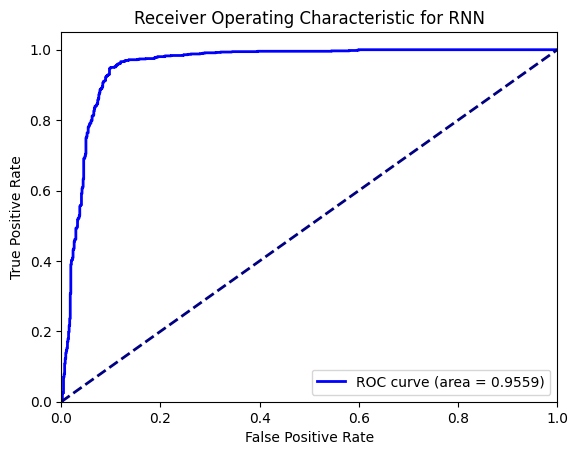

In [ ]:
# Define the RNN model
def create_rnn_model(input_shape):
    model = Sequential([
        SimpleRNN(8, return_sequences=True, input_shape=input_shape),
        Dropout(0.5),
        SimpleRNN(4, return_sequences=False),  # Only return the final output
        Dropout(0.5),
        Dense(4, activation='relu'),
        Dense(1, activation='sigmoid')  # Use 'sigmoid' for binary classification
    ])
    return model

# Assuming input_shape based on the final_train_df without the target column
input_shape = (1, final_train_df.shape[1] - 1)  # Only one timestep, features equal to number of columns minus target

# Create the model
model = create_rnn_model(input_shape)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Convert target data to float32 to avoid TypeError
y_train = final_train_df['Wildfire'].astype('float32').values
y_val = final_val_df['Wildfire'].astype('float32').values
y_test = final_test_df['Wildfire'].astype('float32').values

# Reshape data to fit the RNN input requirements: [samples, timesteps, features]
X_train = final_train_df.drop('Wildfire', axis=1).values.reshape(-1, 1, final_train_df.shape[1] - 1)
X_val = final_val_df.drop('Wildfire', axis=1).values.reshape(-1, 1, final_val_df.shape[1] - 1)
X_test = final_test_df.drop('Wildfire', axis=1).values.reshape(-1, 1, final_test_df.shape[1] - 1)

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Predict probabilities for ROC curve
y_pred_probs = model.predict(X_test).ravel()

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for RNN')
plt.legend(loc="lower right")
plt.show()


In [ ]:
def initialize_bwo_population(pop_size, param_bounds):
    population = []
    for _ in range(pop_size):
        spider = {
            'units': np.random.randint(param_bounds['units'][0], param_bounds['units'][1] + 1),
            'dropout': np.random.uniform(param_bounds['dropout'][0], param_bounds['dropout'][1])
        }
        population.append(spider)
    return population


In [ ]:
def bwo_crossover_and_cannibalism(population):
    # This is a simplified version. You will need to adapt it based on actual BWO behavior.
    new_population = []
    for spider in population:
        if np.random.rand() < 0.5:  # Random chance to mate
            partner = np.random.choice(population)
            child = {
                'units': int((spider['units'] + partner['units']) / 2),
                'dropout': (spider['dropout'] + partner['dropout']) / 2
            }
            new_population.append(child)
        else:
            new_population.append(spider)
    return new_population


In [ ]:
def bwo_select_survivors(population, max_population_size):
    # Sort by fitness and select the top survivors
    sorted_population = sorted(population, key=lambda x: x['fitness'])
    return sorted_population[:max_population_size]


In [ ]:
def bwo_optimize_rnn(X_train, y_train, X_val, y_val):
    param_bounds = {'units': (10, 50), 'dropout': (0.1, 0.5)}
    population = initialize_bwo_population(10, param_bounds)
    max_generations = 20

    best_fitness = float('inf')
    best_params = None

    for generation in range(max_generations):
        for spider in population:
            params = {'units': spider['units'], 'dropout': spider['dropout']}
            model = create_rnn_model(params, X_train.shape[2])
            model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
            model.fit(X_train, y_train, epochs=20, verbose=0)
            loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
            spider['fitness'] = loss  # Lower loss is better

            if spider['fitness'] < best_fitness:
                best_fitness = spider['fitness']
                best_params = spider

        population = bwo_crossover_and_cannibalism(population)
        population = bwo_select_survivors(population, 10)

    return best_params


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming the following optimal parameters were found
optimal_params = {
    'units': 32,
    'dropout': 0.3
}

def create_optimized_rnn_model(params, input_feature_count):
    model = Sequential([
        SimpleRNN(params['units'], input_shape=(1, input_feature_count), return_sequences=True),
        Dropout(params['dropout']),
        SimpleRNN(params['units'], return_sequences=False),
        Dropout(params['dropout']),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

# Assuming input_shape based on your dataset
input_feature_count = X_train.shape[2]  # Assuming X_train is already appropriately shaped

# Create the model with optimal parameters
model = create_optimized_rnn_model(optimal_params, input_feature_count)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/20
263/263 [==============================] - 4s 6ms/step - loss: 0.3861 - accuracy: 0.8279 - val_loss: 0.2258 - val_accuracy: 0.9256
Epoch 2/20
263/263 [==============================] - 1s 5ms/step - loss: 0.2567 - accuracy: 0.9100 - val_loss: 0.2170 - val_accuracy: 0.9272
Epoch 3/20
263/263 [==============================] - 2s 6ms/step - loss: 0.2350 - accuracy: 0.9152 - val_loss: 0.2095 - val_accuracy: 0.9267
Epoch 4/20
263/263 [==============================] - 2s 8ms/step - loss: 0.2347 - accuracy: 0.9167 - val_loss: 0.2077 - val_accuracy: 0.9294
Epoch 5/20
263/263 [==============================] - 2s 7ms/step - loss: 0.2269 - accuracy: 0.9176 - val_loss: 0.2058 - val_accuracy: 0.9294
Epoch 6/20
263/263 [==============================] - 1s 5ms/step - loss: 0.2197 - accuracy: 0.9170 - val_loss: 0.2014 - val_accuracy: 0.9294
Epoch 7/20
263/263 [==============================] - 1s 5ms/step - loss: 0.2190 - accuracy: 0.9189 - val_loss: 0.2011 - val_accuracy: 0.9278
Epoch 

57/57 [==============================] - 0s 3ms/step


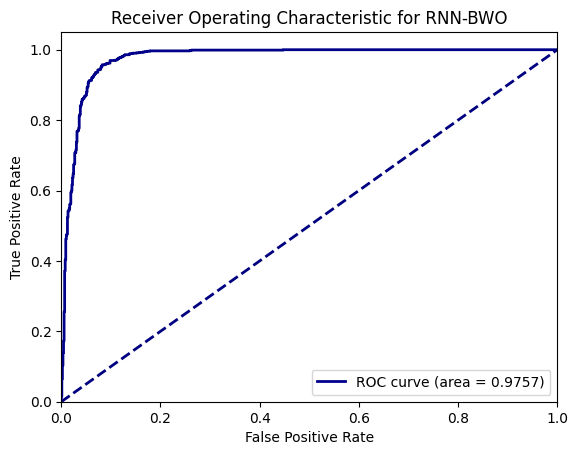

In [ ]:
# Predict probabilities for the test set
y_pred_probs = model.predict(X_test).ravel()

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkblue', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for RNN-BWO')
plt.legend(loc="lower right")
plt.show()


In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/Export_Output1_with_lat_long.csv', names= ['pointid', 'grid_code', 'aspect', 'temp_july', 'soilmois', 'slope', 'ndvi',
                                      'lulc', 'dist_lake', 'elevation', 'dist_road', 'dist_river', 'pcp',
                                      'Latitude', 'Longitude'
                                                   ], header= 0)

In [ ]:
col_to_drop = ['pointid', 'grid_code']
df1 = df1.drop(columns= col_to_drop, axis= 1)

In [ ]:
# Assuming your dataframe is named df1
df1.replace(-9999, np.nan, inplace=True)

# To check if the replacement worked and see the count of null values in each column
null_counts = df1.isnull().sum()
print(null_counts)


aspect          0
temp_july       0
soilmois      509
slope           0
ndvi          514
lulc            0
dist_lake       0
elevation       0
dist_road      76
dist_river     77
pcp           510
Latitude        0
Longitude       0
dtype: int64


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Assuming your dataframe is named df1
# Separate the rows with and without missing values
df_missing = df1[df1.isnull().any(axis=1)]
df_not_missing = df1.dropna()

# Define the features (latitude and longitude) and target
features = ['Latitude', 'Longitude']
target_columns = df1.columns[df1.isnull().any()].tolist()  # Columns with missing values

# For each target column with missing values, we will use KNN to impute the values
for target in target_columns:
    # Prepare the training data
    X_train = df_not_missing[features]
    y_train = df_not_missing[target]

    # Prepare the data to be imputed
    X_missing = df_missing[features]

    # Initialize and fit the KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=3)  # Using 3 nearest neighbors, you can adjust this number
    knn.fit(X_train, y_train)

    # Predict the missing values
    imputed_values = knn.predict(X_missing)

    # Fill the missing values in the original dataframe
    df1.loc[df_missing.index, target] = imputed_values

# Check again for any remaining null values
null_counts_after_imputation = df1.isnull().sum()
print(null_counts_after_imputation)


aspect        0
temp_july     0
soilmois      0
slope         0
ndvi          0
lulc          0
dist_lake     0
elevation     0
dist_road     0
dist_river    0
pcp           0
Latitude      0
Longitude     0
dtype: int64


In [ ]:
df1 = df1.astype(
    {
        'aspect': 'category',
        'temp_july': 'category',
        'soilmois': 'category',
        'slope': 'category',
        'ndvi': 'category',
        'lulc': 'category',
        'dist_lake': 'category',
        'elevation': 'category',
        'dist_road': 'category',
        'dist_river': 'category',
        'pcp': 'category'
    }
)

In [ ]:
df1.head()

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude
0,4,4,4.0,2,5.0,4,1,2,1.0,2.0,3.0,45.478238,-80.333373
1,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.474184,-80.308844
2,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.470122,-80.284320
3,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.466055,-80.259800
4,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.461980,-80.235285


In [ ]:
col_to_drop = ['Latitude', 'Longitude']
df1_new = df1.drop(columns= col_to_drop, axis= 1)

In [ ]:
df1.shape

(1000001, 13)

In [ ]:
df1_new.shape

(1000001, 11)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Use the trained encoder to transform the categorical data
encoded_data_new = encoder.transform(df1_new[categorical_columns])

# Convert the encoded data to DataFrame
encoded_df_new = pd.DataFrame(encoded_data_new, columns=encoder.get_feature_names_out())

# Concatenate the encoded DataFrame with the non-categorical data
final_df_new = pd.concat([df1_new.drop(categorical_columns, axis=1), encoded_df_new], axis=1)

# Ensure to drop any columns that are not used by the model
# final_df_new.drop(['Latitude', 'Longitude', 'pointid', 'grid_code'], axis=1, inplace=True)

# Reshape data to fit RNN input requirements
X_new = final_df_new.values.reshape(-1, 1, final_df_new.shape[1])

# Load your trained RNN model (if not already loaded)

# Predict using RNN model
predictions = model.predict(X_new)

predictions_df = pd.DataFrame(predictions, columns=['WF_RNN_BWO']).round(3)

# Display the last 10 entries
predictions_df.tail(10)



31251/31251 [==============================] - 78s 2ms/step


,WF_RNN_BWO
999991,0.968
999992,0.963
999993,0.963
999994,0.960
999995,0.968
999996,0.962
999997,0.965
999998,0.979
999999,0.980
1000000,0.969


In [ ]:
# Ensure the predictions DataFrame is properly aligned with the original DataFrame
df1['WF_RNN_BWO'] = predictions_df['WF_RNN_BWO'].values

In [ ]:
df1.head(10)

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude,WF_RNN_BWO
0,4,4,4.0,2,5.0,4,1,2,1.0,2.0,3.0,45.478238,-80.333373,0.029
1,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.474184,-80.308844,0.018
2,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.470122,-80.284320,0.018
3,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.466055,-80.259800,0.012
4,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.461980,-80.235285,0.012
5,3,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.457899,-80.210774,0.011
6,4,4,4.0,3,5.0,4,1,2,0.0,3.0,3.0,45.453812,-80.186268,0.021
7,4,4,4.0,2,5.0,3,1,2,0.0,2.0,3.0,45.449718,-80.161766,0.004
8,4,4,4.0,2,5.0,4,1,2,0.0,2.0,3.0,45.445617,-80.137269,0.028
9,4,4,4.0,3,5.0,4,1,2,0.0,2.0,3.0,45.441510,-80.112776,0.034


In [ ]:
df1.tail(10)

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude,WF_RNN_BWO
999991,5,2,1.0,3,3.0,8,3,3,3.0,4.0,3.0,51.881635,-66.016225,0.968
999992,5,2,1.0,4,3.0,4,3,3,3.0,4.0,3.0,51.873640,-65.989881,0.963
999993,5,2,1.0,4,3.0,4,3,3,3.0,4.0,3.0,51.865639,-65.963548,0.963
999994,5,2,1.0,5,3.0,4,3,3,3.0,4.0,3.0,51.857631,-65.937225,0.960
999995,4,2,1.0,4,3.0,4,3,3,3.0,4.0,3.0,51.849616,-65.910913,0.968
999996,3,2,1.0,2,3.0,4,3,3,3.0,4.0,3.0,51.841595,-65.884612,0.962
999997,3,2,1.0,3,3.0,11,3,3,3.0,4.0,3.0,51.833568,-65.858322,0.965
999998,5,2,1.0,3,3.0,4,3,3,3.0,4.0,3.0,51.825534,-65.832042,0.979
999999,4,2,1.0,3,3.0,4,3,3,3.0,4.0,3.0,51.817493,-65.805774,0.980
1000000,5,2,1.0,2,3.0,4,3,3,3.0,4.0,3.0,51.809446,-65.779515,0.969


# Predict the Probability for the Export output 2 csv Using RNN-BWO model

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/Export_Output_2_with_lat_long.csv', names= ['pointid', 'grid_code', 'aspect', 'temp_july', 'soilmois', 'slope', 'ndvi',
                                      'lulc', 'dist_lake', 'elevation', 'dist_road', 'dist_river', 'pcp',
                                      'Latitude', 'Longitude'
                                                   ], header= 0)

In [ ]:
col_to_drop = ['pointid', 'grid_code']
df2 = df2.drop(columns= col_to_drop, axis= 1)

In [ ]:
# Assuming your dataframe is named df1
df2.replace(-9999, np.nan, inplace=True)

# To check if the replacement worked and see the count of null values in each column
null_counts = df2.isnull().sum()
print(null_counts)


aspect          0
temp_july       0
soilmois      879
slope           0
ndvi          859
lulc            0
dist_lake       0
elevation       0
dist_road     124
dist_river    124
pcp           881
Latitude        0
Longitude       0
dtype: int64


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Assuming your dataframe is named df1
# Separate the rows with and without missing values
df_missing = df2[df2.isnull().any(axis=1)]
df_not_missing = df2.dropna()

# Define the features (latitude and longitude) and target
features = ['Latitude', 'Longitude']
target_columns = df2.columns[df2.isnull().any()].tolist()  # Columns with missing values

# For each target column with missing values, we will use KNN to impute the values
for target in target_columns:
    # Prepare the training data
    X_train = df_not_missing[features]
    y_train = df_not_missing[target]

    # Prepare the data to be imputed
    X_missing = df_missing[features]

    # Initialize and fit the KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=3)  # Using 3 nearest neighbors, you can adjust this number
    knn.fit(X_train, y_train)

    # Predict the missing values
    imputed_values = knn.predict(X_missing)

    # Fill the missing values in the original dataframe
    df2.loc[df_missing.index, target] = imputed_values

# Check again for any remaining null values
null_counts_after_imputation = df2.isnull().sum()
print(null_counts_after_imputation)


aspect        0
temp_july     0
soilmois      0
slope         0
ndvi          0
lulc          0
dist_lake     0
elevation     0
dist_road     0
dist_river    0
pcp           0
Latitude      0
Longitude     0
dtype: int64


In [ ]:
df2 = df2.astype(
    {
        'aspect': 'category',
        'temp_july': 'category',
        'soilmois': 'category',
        'slope': 'category',
        'ndvi': 'category',
        'lulc': 'category',
        'dist_lake': 'category',
        'elevation': 'category',
        'dist_road': 'category',
        'dist_river': 'category',
        'pcp': 'category'
    }
)

In [ ]:
col_to_drop = ['Latitude', 'Longitude']
df2_new = df2.drop(columns= col_to_drop, axis= 1)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Use the trained encoder to transform the categorical data
encoded_data_new2 = encoder.transform(df2_new[categorical_columns])

# Convert the encoded data to DataFrame
encoded_df_new2 = pd.DataFrame(encoded_data_new2, columns=encoder.get_feature_names_out())

# Concatenate the encoded DataFrame with the non-categorical data
final_df_new2 = pd.concat([df2_new.drop(categorical_columns, axis=1), encoded_df_new2], axis=1)

# Ensure to drop any columns that are not used by the model
# final_df_new.drop(['Latitude', 'Longitude', 'pointid', 'grid_code'], axis=1, inplace=True)

# Reshape data to fit RNN input requirements
X_new2 = final_df_new2.values.reshape(-1, 1, final_df_new2.shape[1])


# Predict using BiLSTM model
predictions = model.predict(X_new2)

# Optionally, convert predictions to a DataFrame or other format as needed
predictions_df2 = pd.DataFrame(predictions, columns=['WF_RNN_BWO'])

# Round the predictions to 2 decimal places
predictions_df2['WF_RNN_BWO'] = predictions_df2['WF_RNN_BWO'].round(3)

# Display the last 10 entries
predictions_df2.tail(10)



31785/31785 [==============================] - 83s 3ms/step


,WF_RNN_BWO
1017092,0.001
1017093,0.001
1017094,0.001
1017095,0.000
1017096,0.001
1017097,0.001
1017098,0.001
1017099,0.001
1017100,0.000
1017101,0.000


In [ ]:
# Ensure the predictions DataFrame is properly aligned with the original DataFrame
df2['WF_RNN_BWO'] = predictions_df2['WF_RNN_BWO'].values

In [ ]:
df1.head()

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude,WF_RNN_BWO
0,4,4,4.0,2,5.0,4,1,2,1.0,2.0,3.0,45.478238,-80.333373,0.029
1,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.474184,-80.308844,0.018
2,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.470122,-80.284320,0.018
3,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.466055,-80.259800,0.012
4,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.461980,-80.235285,0.012


In [ ]:
df2.head()

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude,WF_RNN_BWO
0,3,2,1.0,4,3.0,4,3,3,3.0,4.0,2.0,51.801392,-65.753268,0.975
1,2,2,1.0,2,3.0,4,3,3,3.0,4.0,3.0,51.793332,-65.727031,0.971
2,3,2,1.0,4,3.0,5,3,3,3.0,4.0,3.0,51.785265,-65.700805,0.946
3,4,2,1.0,3,3.0,5,3,3,3.0,4.0,3.0,51.777192,-65.674590,0.973
4,5,2,1.0,2,3.0,4,3,3,3.0,4.0,3.0,51.769113,-65.648385,0.969


In [ ]:
col_to_drop = ['aspect', 'temp_july', 'soilmois', 'slope',
               'slope', 'ndvi', 'lulc', 'dist_lake', 'elevation',
               'dist_road', 'dist_river', 'pcp', 'Latitude', 'Longitude']
df1_final = df1.drop(columns= col_to_drop, axis= 1)

In [ ]:
col_to_drop = ['aspect', 'temp_july', 'soilmois', 'slope',
               'slope', 'ndvi', 'lulc', 'dist_lake', 'elevation',
               'dist_road', 'dist_river', 'pcp', 'Latitude', 'Longitude']
df2_final = df2.drop(columns= col_to_drop, axis= 1)

In [ ]:
# Add an 'id' column starting from 0 to the length of the DataFrame minus one
df1_final['FID'] = range(0, len(df1_final))
df2_final['FID'] = range(0, len(df2_final))

In [ ]:
df1_final.to_csv('WF_Export1_RNN_BWO.csv', index=False)

In [ ]:
df2_final.to_csv('WF_Export2_RNN_BWO.csv', index=False)

# Predict the Probability for the Export output 1 csv Using BiRNN-BWO model

In [ ]:
df = pd.read_csv('DATA.csv', names= ['Wildfire', 'X', 'Y', 'twi', 'aspect', 'temp_july', 'temp_max',
                                       'soilmois', 'slope', 'ndvi', 'lulc', 'dist_lake', 'evt_aug',
                                       'elevation', 'dist_road', 'dist_river', 'pcp', 'index'
                                                   ], header= 0
                      )
df = df.astype(
    {
        'Wildfire': 'category',
        'twi': 'category',
        'aspect': 'category',
        'temp_july': 'category',
        'temp_max': 'category',
        'soilmois': 'category',
        'slope': 'category',
        'ndvi': 'category',
        'lulc': 'category',
        'dist_lake': 'category',
        'evt_aug': 'category',
        'elevation': 'category',
        'dist_road': 'category',
        'dist_river': 'category',
        'pcp': 'category'
    }
)
new_order = [
             'index', 'X', 'Y', 'twi', 'aspect', 'temp_july', 'temp_max', 'soilmois', 'slope', 'ndvi',
             'lulc', 'dist_lake', 'evt_aug', 'elevation', 'dist_road', 'dist_river', 'pcp',  'Wildfire'
            ]
df = df[new_order]
col_to_drop = ['index', 'X', 'Y']
df = df.drop(columns= col_to_drop, axis= 1)
col_to_drop = ['temp_max', 'evt_aug', 'twi']
df = df.drop(columns= col_to_drop, axis= 1)

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

categorical_columns = [
    'aspect', 'temp_july', 'soilmois', 'slope', 'ndvi', 'lulc',
    'dist_lake', 'elevation', 'dist_road', 'dist_river', 'pcp'
]

# Prepare the features and target variable without dropping any columns
X = df.drop(['Wildfire'], axis=1)
y = df['Wildfire']

# Split data into training and remaining sets (temporary set for further split into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42                     )

# Split the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop='first')

# Fit the encoder on training data and transform the training, validation, and test data for categorical columns
encoder.fit(X_train[categorical_columns])
encoded_train = encoder.transform(X_train[categorical_columns])
encoded_val = encoder.transform(X_val[categorical_columns])
encoded_test = encoder.transform(X_test[categorical_columns])

# Convert the encoded features into a DataFrame
encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(categorical_columns))
encoded_val_df = pd.DataFrame(encoded_val, columns=encoder.get_feature_names_out(categorical_columns))
encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the encoded features with the non-categorical data
final_train_df = pd.concat([X_train.drop(categorical_columns, axis=1).reset_index(drop=True), encoded_train_df], axis=1)
final_val_df = pd.concat([X_val.drop(categorical_columns, axis=1).reset_index(drop=True), encoded_val_df], axis=1)
final_test_df = pd.concat([X_test.drop(categorical_columns, axis=1).reset_index(drop=True), encoded_test_df], axis=1)

# Add the target variable 'Wildfire' back to the final datasets
final_train_df['Wildfire'] = y_train.reset_index(drop=True)
final_val_df['Wildfire'] = y_val.reset_index(drop=True)
final_test_df['Wildfire'] = y_test.reset_index(drop=True)



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/5
263/263 [==============================] - 7s 11ms/step - loss: 0.6307 - accuracy: 0.6412 - val_loss: 0.3756 - val_accuracy: 0.8956
Epoch 2/5
263/263 [==============================] - 3s 10ms/step - loss: 0.3956 - accuracy: 0.8449 - val_loss: 0.2415 - val_accuracy: 0.9183
Epoch 3/5
263/263 [==============================] - 1s 6ms/step - loss: 0.3184 - accuracy: 0.8887 - val_loss: 0.2294 - val_accuracy: 0.9206
Epoch 4/5
263/263 [==============================] - 2s 6ms/step - loss: 0.2978 - accuracy: 0.8973 - val_loss: 0.2250 - val_accuracy: 0.9228
Epoch 5/5
57/57 [==============================] - 0s 3ms/step - loss: 0.2294 - accuracy: 0.9261
Test Loss: 0.22940947115421295
Test Accuracy: 0.926111102104187
57/57 [==============================] - 1s 2ms/step


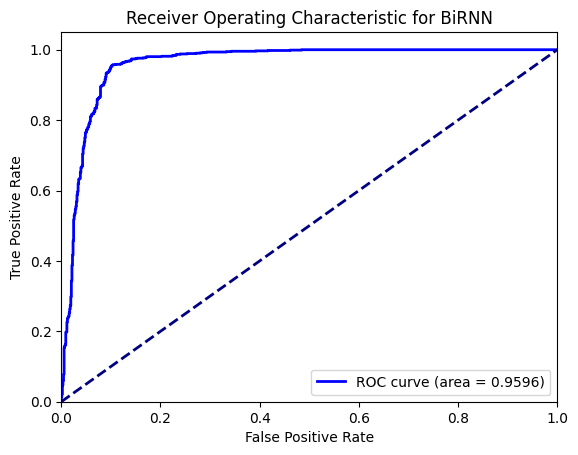

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Define the BiRNN model
def create_birnn_model(input_shape):
    model = Sequential([
        Bidirectional(SimpleRNN(8, return_sequences=True), input_shape=input_shape),
        Dropout(0.5),
        Bidirectional(SimpleRNN(4, return_sequences=False)),  # Only return the final output
        Dropout(0.5),
        Dense(4, activation='relu'),
        Dense(1, activation='sigmoid')  # Use 'sigmoid' for binary classification
    ])
    return model

# Assuming input_shape based on the final_train_df without the target column
input_shape = (1, final_train_df.shape[1] - 1)  # Only one timestep, features equal to number of columns minus target

# Create the model
model = create_birnn_model(input_shape)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Convert target data to float32 to avoid TypeError
y_train = final_train_df['Wildfire'].astype('float32').values
y_val = final_val_df['Wildfire'].astype('float32').values
y_test = final_test_df['Wildfire'].astype('float32').values

# Reshape data to fit the RNN input requirements: [samples, timesteps, features]
X_train = final_train_df.drop('Wildfire', axis=1).values.reshape(-1, 1, final_train_df.shape[1] - 1)
X_val = final_val_df.drop('Wildfire', axis=1).values.reshape(-1, 1, final_val_df.shape[1] - 1)
X_test = final_test_df.drop('Wildfire', axis=1).values.reshape(-1, 1, final_test_df.shape[1] - 1)

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predict probabilities for ROC curve
y_pred_probs = model.predict(X_test).ravel()

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for BiRNN')
plt.legend(loc="lower right")
plt.show()


Generation 1/10, Best Fitness: 0.1503002792596817
Generation 2/10, Best Fitness: 0.1503002792596817
Generation 3/10, Best Fitness: 0.14503604173660278
Generation 4/10, Best Fitness: 0.14503604173660278
Generation 5/10, Best Fitness: 0.14503604173660278
Generation 6/10, Best Fitness: 0.14503604173660278
Generation 7/10, Best Fitness: 0.1448003202676773
Generation 8/10, Best Fitness: 0.1448003202676773
Generation 9/10, Best Fitness: 0.1448003202676773
Generation 10/10, Best Fitness: 0.14186905324459076
Best Parameters: {'units': 37, 'dropout': 0.2636162545902536, 'fitness': 0.14186905324459076}
Epoch 1/30
263/263 [==============================] - 8s 8ms/step - loss: 0.3156 - accuracy: 0.8725 - val_loss: 0.2138 - val_accuracy: 0.9250
Epoch 2/30
263/263 [==============================] - 1s 5ms/step - loss: 0.2315 - accuracy: 0.9162 - val_loss: 0.2056 - val_accuracy: 0.9272
Epoch 3/30
263/263 [==============================] - 1s 6ms/step - loss: 0.2174 - accuracy: 0.9199 - val_loss: 0.19

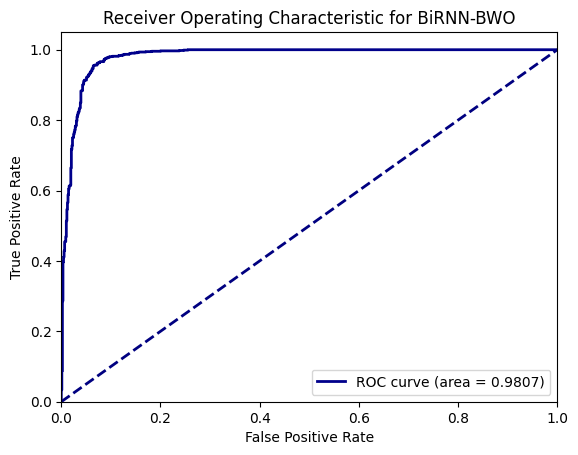

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Define the BiRNN model creation function
def create_birnn_model(params, input_feature_count):
    model = Sequential([
        Bidirectional(SimpleRNN(params['units'], return_sequences=True), input_shape=(1, input_feature_count)),
        Dropout(params['dropout']),
        Bidirectional(SimpleRNN(params['units'], return_sequences=False)),
        Dropout(params['dropout']),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

# Initialize BWO population
def initialize_bwo_population(pop_size, param_bounds):
    population = []
    for _ in range(pop_size):
        spider = {
            'units': np.random.randint(param_bounds['units'][0], param_bounds['units'][1] + 1),
            'dropout': np.random.uniform(param_bounds['dropout'][0], param_bounds['dropout'][1]),
            'fitness': None  # Initialize fitness
        }
        population.append(spider)
    return population

# BWO Crossover and Cannibalism
def bwo_crossover_and_cannibalism(population):
    new_population = []
    for spider in population:
        if np.random.rand() < 0.5:  # Random chance to mate
            partner = np.random.choice(population)
            child = {
                'units': int((spider['units'] + partner['units']) / 2),
                'dropout': (spider['dropout'] + partner['dropout']) / 2,
                'fitness': None  # Reset fitness for new child
            }
            new_population.append(child)
        else:
            new_population.append(spider)
    return new_population

# Select survivors based on fitness
def bwo_select_survivors(population, max_population_size):
    # Ensure all spiders have a fitness value
    for spider in population:
        if spider['fitness'] is None:
            spider['fitness'] = float('inf')  # Assign worst fitness if not evaluated
    # Sort by fitness and select the top survivors
    sorted_population = sorted(population, key=lambda x: x['fitness'])
    return sorted_population[:max_population_size]

# Optimize BiRNN using BWO
def bwo_optimize_birnn(X_train, y_train, X_val, y_val):
    param_bounds = {'units': (10, 50), 'dropout': (0.1, 0.5)}
    population = initialize_bwo_population(10, param_bounds)
    max_generations = 10

    best_fitness = float('inf')
    best_params = None

    for generation in range(max_generations):
        for spider in population:
            params = {'units': spider['units'], 'dropout': spider['dropout']}
            model = create_birnn_model(params, X_train.shape[2])
            model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
            model.fit(X_train, y_train, epochs=30, verbose=0)  # Reduced verbosity for optimization
            loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
            spider['fitness'] = loss  # Lower loss is better

            if spider['fitness'] < best_fitness:
                best_fitness = spider['fitness']
                best_params = spider

        population = bwo_crossover_and_cannibalism(population)
        population = bwo_select_survivors(population, 10)
        print(f"Generation {generation+1}/{max_generations}, Best Fitness: {best_fitness}")

    return best_params

# Assuming X_train, X_val, y_train, y_val, X_test, and y_test are already defined
input_feature_count = X_train.shape[2]

# Optimize the BiRNN using BWO
best_params = bwo_optimize_birnn(X_train, y_train, X_val, y_val)
print(f"Best Parameters: {best_params}")

# Create the model with optimal parameters
model = create_birnn_model(best_params, input_feature_count)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predict probabilities for the test set
y_pred_probs = model.predict(X_test).ravel()

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkblue', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for BiRNN-BWO')
plt.legend(loc="lower right")
plt.show()


In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/Export_Output1_with_lat_long.csv', names= ['pointid', 'grid_code', 'aspect', 'temp_july', 'soilmois', 'slope', 'ndvi',
                                      'lulc', 'dist_lake', 'elevation', 'dist_road', 'dist_river', 'pcp',
                                      'Latitude', 'Longitude'
                                                   ], header= 0)

In [ ]:
col_to_drop = ['pointid', 'grid_code']
df1 = df1.drop(columns= col_to_drop, axis= 1)

In [ ]:
# Assuming your dataframe is named df1
df1.replace(-9999, np.nan, inplace=True)

# To check if the replacement worked and see the count of null values in each column
null_counts = df1.isnull().sum()
print(null_counts)


aspect          0
temp_july       0
soilmois      509
slope           0
ndvi          514
lulc            0
dist_lake       0
elevation       0
dist_road      76
dist_river     77
pcp           510
Latitude        0
Longitude       0
dtype: int64


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Assuming your dataframe is named df1
# Separate the rows with and without missing values
df_missing = df1[df1.isnull().any(axis=1)]
df_not_missing = df1.dropna()

# Define the features (latitude and longitude) and target
features = ['Latitude', 'Longitude']
target_columns = df1.columns[df1.isnull().any()].tolist()  # Columns with missing values

# For each target column with missing values, we will use KNN to impute the values
for target in target_columns:
    # Prepare the training data
    X_train = df_not_missing[features]
    y_train = df_not_missing[target]

    # Prepare the data to be imputed
    X_missing = df_missing[features]

    # Initialize and fit the KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=3)  # Using 3 nearest neighbors, you can adjust this number
    knn.fit(X_train, y_train)

    # Predict the missing values
    imputed_values = knn.predict(X_missing)

    # Fill the missing values in the original dataframe
    df1.loc[df_missing.index, target] = imputed_values

# Check again for any remaining null values
null_counts_after_imputation = df1.isnull().sum()
print(null_counts_after_imputation)


aspect        0
temp_july     0
soilmois      0
slope         0
ndvi          0
lulc          0
dist_lake     0
elevation     0
dist_road     0
dist_river    0
pcp           0
Latitude      0
Longitude     0
dtype: int64


In [ ]:
df1 = df1.astype(
    {
        'aspect': 'category',
        'temp_july': 'category',
        'soilmois': 'category',
        'slope': 'category',
        'ndvi': 'category',
        'lulc': 'category',
        'dist_lake': 'category',
        'elevation': 'category',
        'dist_road': 'category',
        'dist_river': 'category',
        'pcp': 'category'
    }
)

In [ ]:
df1.head()

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude
0,4,4,4.0,2,5.0,4,1,2,1.0,2.0,3.0,45.478238,-80.333373
1,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.474184,-80.308844
2,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.470122,-80.284320
3,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.466055,-80.259800
4,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.461980,-80.235285


In [ ]:
col_to_drop = ['Latitude', 'Longitude']
df1_new = df1.drop(columns= col_to_drop, axis= 1)

In [ ]:
df1.shape

(1000001, 13)

In [ ]:
df1_new.shape

(1000001, 11)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Use the trained encoder to transform the categorical data
encoded_data_new = encoder.transform(df1_new[categorical_columns])

# Convert the encoded data to DataFrame
encoded_df_new = pd.DataFrame(encoded_data_new, columns=encoder.get_feature_names_out())

# Concatenate the encoded DataFrame with the non-categorical data
final_df_new = pd.concat([df1_new.drop(categorical_columns, axis=1), encoded_df_new], axis=1)

# Ensure to drop any columns that are not used by the model
# final_df_new.drop(['Latitude', 'Longitude', 'pointid', 'grid_code'], axis=1, inplace=True)

# Reshape data to fit RNN input requirements
X_new = final_df_new.values.reshape(-1, 1, final_df_new.shape[1])

# Load your trained RNN model (if not already loaded)

# Predict using RNN model
predictions = model.predict(X_new)

predictions_df = pd.DataFrame(predictions, columns=['WF_BiRNN_BWO']).round(3)

# Display the last 10 entries
predictions_df.tail(10)



31251/31251 [==============================] - 86s 3ms/step


,WF_BiRNN_BWO
999991,0.901
999992,0.799
999993,0.799
999994,0.773
999995,0.770
999996,0.769
999997,0.769
999998,0.910
999999,0.889
1000000,0.912


In [ ]:
# Ensure the predictions DataFrame is properly aligned with the original DataFrame
df1['WF_BiRNN_BWO'] = predictions_df['WF_BiRNN_BWO'].values

In [ ]:
df1.head(10)

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude,WF_BiRNN_BWO
0,4,4,4.0,2,5.0,4,1,2,1.0,2.0,3.0,45.478238,-80.333373,0.001
1,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.474184,-80.308844,0.001
2,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.470122,-80.284320,0.001
3,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.466055,-80.259800,0.000
4,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.461980,-80.235285,0.000
5,3,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.457899,-80.210774,0.000
6,4,4,4.0,3,5.0,4,1,2,0.0,3.0,3.0,45.453812,-80.186268,0.001
7,4,4,4.0,2,5.0,3,1,2,0.0,2.0,3.0,45.449718,-80.161766,0.000
8,4,4,4.0,2,5.0,4,1,2,0.0,2.0,3.0,45.445617,-80.137269,0.001
9,4,4,4.0,3,5.0,4,1,2,0.0,2.0,3.0,45.441510,-80.112776,0.002


In [ ]:
df1.tail(10)

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude,WF_BiRNN_BWO
999991,5,2,1.0,3,3.0,8,3,3,3.0,4.0,3.0,51.881635,-66.016225,0.901
999992,5,2,1.0,4,3.0,4,3,3,3.0,4.0,3.0,51.873640,-65.989881,0.799
999993,5,2,1.0,4,3.0,4,3,3,3.0,4.0,3.0,51.865639,-65.963548,0.799
999994,5,2,1.0,5,3.0,4,3,3,3.0,4.0,3.0,51.857631,-65.937225,0.773
999995,4,2,1.0,4,3.0,4,3,3,3.0,4.0,3.0,51.849616,-65.910913,0.770
999996,3,2,1.0,2,3.0,4,3,3,3.0,4.0,3.0,51.841595,-65.884612,0.769
999997,3,2,1.0,3,3.0,11,3,3,3.0,4.0,3.0,51.833568,-65.858322,0.769
999998,5,2,1.0,3,3.0,4,3,3,3.0,4.0,3.0,51.825534,-65.832042,0.910
999999,4,2,1.0,3,3.0,4,3,3,3.0,4.0,3.0,51.817493,-65.805774,0.889
1000000,5,2,1.0,2,3.0,4,3,3,3.0,4.0,3.0,51.809446,-65.779515,0.912


# Predict the Probability for the Export output 2 csv Using BiRNN-BWO model

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/Export_Output_2_with_lat_long.csv', names= ['pointid', 'grid_code', 'aspect', 'temp_july', 'soilmois', 'slope', 'ndvi',
                                      'lulc', 'dist_lake', 'elevation', 'dist_road', 'dist_river', 'pcp',
                                      'Latitude', 'Longitude'
                                                   ], header= 0)

In [ ]:
col_to_drop = ['pointid', 'grid_code']
df2 = df2.drop(columns= col_to_drop, axis= 1)

In [ ]:
# Assuming your dataframe is named df1
df2.replace(-9999, np.nan, inplace=True)

# To check if the replacement worked and see the count of null values in each column
null_counts = df2.isnull().sum()
print(null_counts)


aspect          0
temp_july       0
soilmois      879
slope           0
ndvi          859
lulc            0
dist_lake       0
elevation       0
dist_road     124
dist_river    124
pcp           881
Latitude        0
Longitude       0
dtype: int64


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Assuming your dataframe is named df1
# Separate the rows with and without missing values
df_missing = df2[df2.isnull().any(axis=1)]
df_not_missing = df2.dropna()

# Define the features (latitude and longitude) and target
features = ['Latitude', 'Longitude']
target_columns = df2.columns[df2.isnull().any()].tolist()  # Columns with missing values

# For each target column with missing values, we will use KNN to impute the values
for target in target_columns:
    # Prepare the training data
    X_train = df_not_missing[features]
    y_train = df_not_missing[target]

    # Prepare the data to be imputed
    X_missing = df_missing[features]

    # Initialize and fit the KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=3)  # Using 3 nearest neighbors, you can adjust this number
    knn.fit(X_train, y_train)

    # Predict the missing values
    imputed_values = knn.predict(X_missing)

    # Fill the missing values in the original dataframe
    df2.loc[df_missing.index, target] = imputed_values

# Check again for any remaining null values
null_counts_after_imputation = df2.isnull().sum()
print(null_counts_after_imputation)


aspect        0
temp_july     0
soilmois      0
slope         0
ndvi          0
lulc          0
dist_lake     0
elevation     0
dist_road     0
dist_river    0
pcp           0
Latitude      0
Longitude     0
dtype: int64


In [ ]:
df2 = df2.astype(
    {
        'aspect': 'category',
        'temp_july': 'category',
        'soilmois': 'category',
        'slope': 'category',
        'ndvi': 'category',
        'lulc': 'category',
        'dist_lake': 'category',
        'elevation': 'category',
        'dist_road': 'category',
        'dist_river': 'category',
        'pcp': 'category'
    }
)

In [ ]:
col_to_drop = ['Latitude', 'Longitude']
df2_new = df2.drop(columns= col_to_drop, axis= 1)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Use the trained encoder to transform the categorical data
encoded_data_new2 = encoder.transform(df2_new[categorical_columns])

# Convert the encoded data to DataFrame
encoded_df_new2 = pd.DataFrame(encoded_data_new2, columns=encoder.get_feature_names_out())

# Concatenate the encoded DataFrame with the non-categorical data
final_df_new2 = pd.concat([df2_new.drop(categorical_columns, axis=1), encoded_df_new2], axis=1)

# Ensure to drop any columns that are not used by the model
# final_df_new.drop(['Latitude', 'Longitude', 'pointid', 'grid_code'], axis=1, inplace=True)

# Reshape data to fit RNN input requirements
X_new2 = final_df_new2.values.reshape(-1, 1, final_df_new2.shape[1])


# Predict using BiLSTM model
predictions = model.predict(X_new2)

# Optionally, convert predictions to a DataFrame or other format as needed
predictions_df2 = pd.DataFrame(predictions, columns=['WF_BiRNN_BWO'])

# Round the predictions to 2 decimal places
predictions_df2['WF_BiRNN_BWO'] = predictions_df2['WF_BiRNN_BWO'].round(3)

# Display the last 10 entries
predictions_df2.tail(10)



31785/31785 [==============================] - 86s 3ms/step


,WF_BiRNN_BWO
1017092,0.0
1017093,0.0
1017094,0.0
1017095,0.0
1017096,0.0
1017097,0.0
1017098,0.0
1017099,0.0
1017100,0.0
1017101,0.0


In [ ]:
# Ensure the predictions DataFrame is properly aligned with the original DataFrame
df2['WF_BiRNN_BWO'] = predictions_df2['WF_BiRNN_BWO'].values

In [ ]:
df1.head()

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude,WF_BiRNN_BWO
0,4,4,4.0,2,5.0,4,1,2,1.0,2.0,3.0,45.478238,-80.333373,0.001
1,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.474184,-80.308844,0.001
2,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.470122,-80.284320,0.001
3,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.466055,-80.259800,0.000
4,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.461980,-80.235285,0.000


In [ ]:
df2.head()

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude,WF_BiRNN_BWO
0,3,2,1.0,4,3.0,4,3,3,3.0,4.0,2.0,51.801392,-65.753268,0.940
1,2,2,1.0,2,3.0,4,3,3,3.0,4.0,3.0,51.793332,-65.727031,0.876
2,3,2,1.0,4,3.0,5,3,3,3.0,4.0,3.0,51.785265,-65.700805,0.503
3,4,2,1.0,3,3.0,5,3,3,3.0,4.0,3.0,51.777192,-65.674590,0.842
4,5,2,1.0,2,3.0,4,3,3,3.0,4.0,3.0,51.769113,-65.648385,0.912


In [ ]:
col_to_drop = ['aspect', 'temp_july', 'soilmois', 'slope',
               'slope', 'ndvi', 'lulc', 'dist_lake', 'elevation',
               'dist_road', 'dist_river', 'pcp', 'Latitude', 'Longitude']
df1_final = df1.drop(columns= col_to_drop, axis= 1)

In [ ]:
col_to_drop = ['aspect', 'temp_july', 'soilmois', 'slope',
               'slope', 'ndvi', 'lulc', 'dist_lake', 'elevation',
               'dist_road', 'dist_river', 'pcp', 'Latitude', 'Longitude']
df2_final = df2.drop(columns= col_to_drop, axis= 1)

In [ ]:
# Add an 'id' column starting from 0 to the length of the DataFrame minus one
df1_final['FID'] = range(0, len(df1_final))
df2_final['FID'] = range(0, len(df2_final))

In [ ]:
df1_final.to_csv('WF_Export1_BiRNN_BWO.csv', index=False)

In [ ]:
df2_final.to_csv('WF_Export2_BiRNN_BWO.csv', index=False)

# Predict the Probability for the Export output 1 csv file using LSTM_BWO model

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
df = pd.read_csv('DATA.csv', names= ['Wildfire', 'X', 'Y', 'twi', 'aspect', 'temp_july', 'temp_max',
                                       'soilmois', 'slope', 'ndvi', 'lulc', 'dist_lake', 'evt_aug',
                                       'elevation', 'dist_road', 'dist_river', 'pcp', 'index'
                                                   ], header= 0
                      )
df = df.astype(
    {
        'Wildfire': 'category',
        'twi': 'category',
        'aspect': 'category',
        'temp_july': 'category',
        'temp_max': 'category',
        'soilmois': 'category',
        'slope': 'category',
        'ndvi': 'category',
        'lulc': 'category',
        'dist_lake': 'category',
        'evt_aug': 'category',
        'elevation': 'category',
        'dist_road': 'category',
        'dist_river': 'category',
        'pcp': 'category'
    }
)
new_order = [
             'index', 'X', 'Y', 'twi', 'aspect', 'temp_july', 'temp_max', 'soilmois', 'slope', 'ndvi',
             'lulc', 'dist_lake', 'evt_aug', 'elevation', 'dist_road', 'dist_river', 'pcp',  'Wildfire'
            ]
df = df[new_order]
col_to_drop = ['index', 'X', 'Y']
df = df.drop(columns= col_to_drop, axis= 1)
col_to_drop = ['temp_max', 'evt_aug', 'twi']
df = df.drop(columns= col_to_drop, axis= 1)
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

categorical_columns = [
    'aspect', 'temp_july', 'soilmois', 'slope', 'ndvi', 'lulc',
    'dist_lake', 'elevation', 'dist_road', 'dist_river', 'pcp'
]

# Prepare the features and target variable without dropping any columns
X = df.drop(['Wildfire'], axis=1)
y = df['Wildfire']

# Split data into training and remaining sets (temporary set for further split into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42                     )

# Split the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop='first')

# Fit the encoder on training data and transform the training, validation, and test data for categorical columns
encoder.fit(X_train[categorical_columns])
encoded_train = encoder.transform(X_train[categorical_columns])
encoded_val = encoder.transform(X_val[categorical_columns])
encoded_test = encoder.transform(X_test[categorical_columns])

# Convert the encoded features into a DataFrame
encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(categorical_columns))
encoded_val_df = pd.DataFrame(encoded_val, columns=encoder.get_feature_names_out(categorical_columns))
encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the encoded features with the non-categorical data
final_train_df = pd.concat([X_train.drop(categorical_columns, axis=1).reset_index(drop=True), encoded_train_df], axis=1)
final_val_df = pd.concat([X_val.drop(categorical_columns, axis=1).reset_index(drop=True), encoded_val_df], axis=1)
final_test_df = pd.concat([X_test.drop(categorical_columns, axis=1).reset_index(drop=True), encoded_test_df], axis=1)

# Add the target variable 'Wildfire' back to the final datasets
final_train_df['Wildfire'] = y_train.reset_index(drop=True)
final_val_df['Wildfire'] = y_val.reset_index(drop=True)
final_test_df['Wildfire'] = y_test.reset_index(drop=True)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
def initialize_bwo_population(pop_size, param_bounds):
    population = []
    for _ in range(pop_size):
        spider = {
            'units': np.random.randint(param_bounds['units'][0], param_bounds['units'][1] + 1),
            'dropout': np.random.uniform(param_bounds['dropout'][0], param_bounds['dropout'][1])
        }
        population.append(spider)
    return population


In [ ]:
def bwo_crossover_and_cannibalism(population):
    # This is a simplified version. You will need to adapt it based on actual BWO behavior.
    new_population = []
    for spider in population:
        if np.random.rand() < 0.5:  # Random chance to mate
            partner = np.random.choice(population)
            child = {
                'units': int((spider['units'] + partner['units']) / 2),
                'dropout': (spider['dropout'] + partner['dropout']) / 2
            }
            new_population.append(child)
        else:
            new_population.append(spider)
    return new_population


In [ ]:
def bwo_select_survivors(population, max_population_size):
    # Sort by fitness and select the top survivors
    sorted_population = sorted(population, key=lambda x: x['fitness'])
    return sorted_population[:max_population_size]


In [ ]:
def bwo_optimize_rnn(X_train, y_train, X_val, y_val):
    param_bounds = {'units': (10, 50), 'dropout': (0.1, 0.5)}
    population = initialize_bwo_population(10, param_bounds)
    max_generations = 20

    best_fitness = float('inf')
    best_params = None

    for generation in range(max_generations):
        for spider in population:
            params = {'units': spider['units'], 'dropout': spider['dropout']}
            model = create_rnn_model(params, X_train.shape[2])
            model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
            model.fit(X_train, y_train, epochs=20, verbose=0)
            loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
            spider['fitness'] = loss  # Lower loss is better

            if spider['fitness'] < best_fitness:
                best_fitness = spider['fitness']
                best_params = spider

        population = bwo_crossover_and_cannibalism(population)
        population = bwo_select_survivors(population, 10)

    return best_params


Epoch 1/5
263/263 [==============================] - 8s 9ms/step - loss: 0.5959 - accuracy: 0.7510 - val_loss: 0.3733 - val_accuracy: 0.9061
Epoch 2/5
263/263 [==============================] - 1s 4ms/step - loss: 0.3864 - accuracy: 0.8674 - val_loss: 0.2587 - val_accuracy: 0.9217
Epoch 3/5
263/263 [==============================] - 1s 5ms/step - loss: 0.3277 - accuracy: 0.8852 - val_loss: 0.2365 - val_accuracy: 0.9267
Epoch 4/5
263/263 [==============================] - 1s 5ms/step - loss: 0.3117 - accuracy: 0.8854 - val_loss: 0.2277 - val_accuracy: 0.9261
Epoch 5/5
57/57 [==============================] - 1s 2ms/step


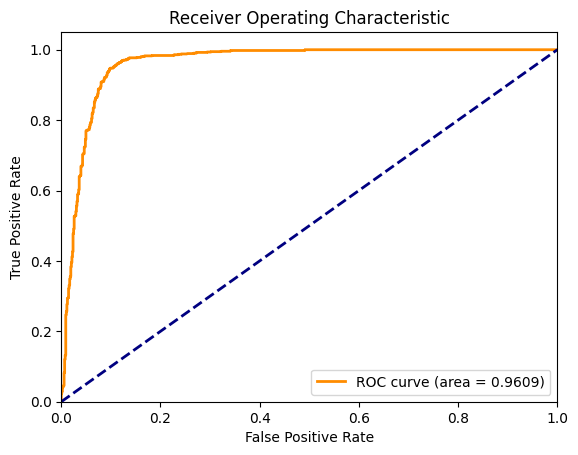

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Define the LSTM model
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(8, return_sequences=True, input_shape=input_shape),
        Dropout(0.5),
        LSTM(4, return_sequences=False),  # Remove return_sequences if you only want the last output
        Dropout(0.5),
        Dense(4, activation='relu'),
        Dense(1, activation='sigmoid')  # Use 'sigmoid' for binary classification
    ])
    return model

# Assuming input_shape based on the final_train_df without the target column
input_shape = (1, final_train_df.shape[1] - 1)  # Only one timestep, features equal to number of columns minus target

# Create the model
model = create_lstm_model(input_shape)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Convert target data to float32 to avoid TypeError
y_train = final_train_df['Wildfire'].astype('float32').values
y_val = final_val_df['Wildfire'].astype('float32').values
y_test = final_test_df['Wildfire'].astype('float32').values

# Reshape data to fit the LSTM input requirements: [samples, timesteps, features]
X_train = final_train_df.drop('Wildfire', axis=1).values.reshape(-1, 1, final_train_df.shape[1] - 1)
X_val = final_val_df.drop('Wildfire', axis=1).values.reshape(-1, 1, final_val_df.shape[1] - 1)
X_test = final_test_df.drop('Wildfire', axis=1).values.reshape(-1, 1, final_test_df.shape[1] - 1)

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Predict probabilities for ROC curve
y_pred_probs = model.predict(X_test).ravel()

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Generation 1/5, Best Fitness: 0.14791159331798553
Generation 2/5, Best Fitness: 0.14225444197654724
Generation 3/5, Best Fitness: 0.14225444197654724
Generation 4/5, Best Fitness: 0.14225444197654724
Generation 5/5, Best Fitness: 0.14225444197654724
Best Parameters: {'units': 36, 'dropout': 0.2559820582217837, 'fitness': 0.15166082978248596}
Epoch 1/20
263/263 [==============================] - 6s 9ms/step - loss: 0.3689 - accuracy: 0.8857 - val_loss: 0.2215 - val_accuracy: 0.9278
Epoch 2/20
263/263 [==============================] - 2s 8ms/step - loss: 0.2272 - accuracy: 0.9196 - val_loss: 0.2085 - val_accuracy: 0.9294
Epoch 3/20
263/263 [==============================] - 2s 8ms/step - loss: 0.2165 - accuracy: 0.9213 - val_loss: 0.1987 - val_accuracy: 0.9361
Epoch 4/20
263/263 [==============================] - 1s 5ms/step - loss: 0.2042 - accuracy: 0.9248 - val_loss: 0.1936 - val_accuracy: 0.9333
Epoch 5/20
263/263 [==============================] - 1s 5ms/step - loss: 0.1965 - accur

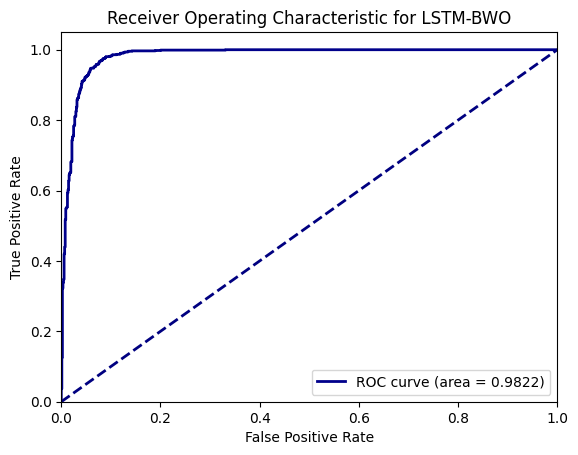

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Define the LSTM model creation function
def create_lstm_model(params, input_feature_count):
    model = Sequential([
        LSTM(params['units'], input_shape=(1, input_feature_count), return_sequences=True),
        Dropout(params['dropout']),
        LSTM(params['units'], return_sequences=False),
        Dropout(params['dropout']),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

# Initialize BWO population
def initialize_bwo_population(pop_size, param_bounds):
    population = []
    for _ in range(pop_size):
        spider = {
            'units': np.random.randint(param_bounds['units'][0], param_bounds['units'][1] + 1),
            'dropout': np.random.uniform(param_bounds['dropout'][0], param_bounds['dropout'][1]),
            'fitness': None  # Initialize fitness
        }
        population.append(spider)
    return population

# BWO Crossover and Cannibalism
def bwo_crossover_and_cannibalism(population):
    new_population = []
    for spider in population:
        if np.random.rand() < 0.5:  # Random chance to mate
            partner = np.random.choice(population)
            child = {
                'units': int((spider['units'] + partner['units']) / 2),
                'dropout': (spider['dropout'] + partner['dropout']) / 2,
                'fitness': None  # Reset fitness for new child
            }
            new_population.append(child)
        else:
            new_population.append(spider)
    return new_population

# Select survivors based on fitness
def bwo_select_survivors(population, max_population_size):
    # Ensure all spiders have a fitness value
    for spider in population:
        if spider['fitness'] is None:
            spider['fitness'] = float('inf')  # Assign worst fitness if not evaluated
    # Sort by fitness and select the top survivors
    sorted_population = sorted(population, key=lambda x: x['fitness'])
    return sorted_population[:max_population_size]

# Optimize LSTM using BWO
def bwo_optimize_lstm(X_train, y_train, X_val, y_val):
    param_bounds = {'units': (10, 50), 'dropout': (0.1, 0.5)}
    population = initialize_bwo_population(5, param_bounds)
    max_generations = 5

    best_fitness = float('inf')
    best_params = None

    for generation in range(max_generations):
        for spider in population:
            params = {'units': spider['units'], 'dropout': spider['dropout']}
            model = create_lstm_model(params, X_train.shape[2])
            model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
            model.fit(X_train, y_train, epochs=20, verbose=0)  # Reduced verbosity for optimization
            loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
            spider['fitness'] = loss  # Lower loss is better

            if spider['fitness'] < best_fitness:
                best_fitness = spider['fitness']
                best_params = spider

        population = bwo_crossover_and_cannibalism(population)
        population = bwo_select_survivors(population, 5)
        print(f"Generation {generation+1}/{max_generations}, Best Fitness: {best_fitness}")

    return best_params

# Assuming X_train, X_val, y_train, y_val, X_test, and y_test are already defined
input_feature_count = X_train.shape[2]

# Optimize the LSTM using BWO
best_params = bwo_optimize_lstm(X_train, y_train, X_val, y_val)
print(f"Best Parameters: {best_params}")

# Create the model with optimal parameters
model = create_lstm_model(best_params, input_feature_count)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predict probabilities for the test set
y_pred_probs = model.predict(X_test).ravel()

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkblue', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for LSTM-BWO')
plt.legend(loc="lower right")
plt.show()


In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/Export_Output1_with_lat_long.csv', names= ['pointid', 'grid_code', 'aspect', 'temp_july', 'soilmois', 'slope', 'ndvi',
                                      'lulc', 'dist_lake', 'elevation', 'dist_road', 'dist_river', 'pcp',
                                      'Latitude', 'Longitude'
                                                   ], header= 0)

In [ ]:
col_to_drop = ['pointid', 'grid_code']
df1 = df1.drop(columns= col_to_drop, axis= 1)

In [ ]:
df1.head()

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude
0,4,4,4,2,5,4,1,2,1,2,3,45.478238,-80.333373
1,4,4,4,2,5,4,1,2,1,3,3,45.474184,-80.308844
2,4,4,4,2,5,4,1,2,1,3,3,45.470122,-80.284320
3,5,4,4,2,5,4,1,2,0,3,3,45.466055,-80.259800
4,5,4,4,2,5,4,1,2,0,3,3,45.461980,-80.235285


In [ ]:
# Assuming your dataframe is named df1
df1.replace(-9999, np.nan, inplace=True)

# To check if the replacement worked and see the count of null values in each column
null_counts = df1.isnull().sum()
print(null_counts)


aspect          0
temp_july       0
soilmois      509
slope           0
ndvi          514
lulc            0
dist_lake       0
elevation       0
dist_road      76
dist_river     77
pcp           510
Latitude        0
Longitude       0
dtype: int64


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Assuming your dataframe is named df1
# Separate the rows with and without missing values
df_missing = df1[df1.isnull().any(axis=1)]
df_not_missing = df1.dropna()

# Define the features (latitude and longitude) and target
features = ['Latitude', 'Longitude']
target_columns = df1.columns[df1.isnull().any()].tolist()  # Columns with missing values

# For each target column with missing values, we will use KNN to impute the values
for target in target_columns:
    # Prepare the training data
    X_train = df_not_missing[features]
    y_train = df_not_missing[target]

    # Prepare the data to be imputed
    X_missing = df_missing[features]

    # Initialize and fit the KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=3)  # Using 3 nearest neighbors, you can adjust this number
    knn.fit(X_train, y_train)

    # Predict the missing values
    imputed_values = knn.predict(X_missing)

    # Fill the missing values in the original dataframe
    df1.loc[df_missing.index, target] = imputed_values

# Check again for any remaining null values
null_counts_after_imputation = df1.isnull().sum()
print(null_counts_after_imputation)


aspect        0
temp_july     0
soilmois      0
slope         0
ndvi          0
lulc          0
dist_lake     0
elevation     0
dist_road     0
dist_river    0
pcp           0
Latitude      0
Longitude     0
dtype: int64


In [ ]:
df1 = df1.astype(
    {
        'aspect': 'category',
        'temp_july': 'category',
        'soilmois': 'category',
        'slope': 'category',
        'ndvi': 'category',
        'lulc': 'category',
        'dist_lake': 'category',
        'elevation': 'category',
        'dist_road': 'category',
        'dist_river': 'category',
        'pcp': 'category'
    }
)

In [ ]:
df1.head()

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude
0,4,4,4.0,2,5.0,4,1,2,1.0,2.0,3.0,45.478238,-80.333373
1,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.474184,-80.308844
2,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.470122,-80.284320
3,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.466055,-80.259800
4,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.461980,-80.235285


In [ ]:
col_to_drop = ['Latitude', 'Longitude']
df1_new = df1.drop(columns= col_to_drop, axis= 1)

In [ ]:
df1.shape

(1000001, 13)

In [ ]:
df1_new.shape

(1000001, 11)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Use the trained encoder to transform the categorical data
encoded_data_new = encoder.transform(df1_new[categorical_columns])

# Convert the encoded data to DataFrame
encoded_df_new = pd.DataFrame(encoded_data_new, columns=encoder.get_feature_names_out())

# Concatenate the encoded DataFrame with the non-categorical data
final_df_new = pd.concat([df1_new.drop(categorical_columns, axis=1), encoded_df_new], axis=1)

# Ensure to drop any columns that are not used by the model
# final_df_new.drop(['Latitude', 'Longitude', 'pointid', 'grid_code'], axis=1, inplace=True)

# Reshape data to fit RNN input requirements
X_new = final_df_new.values.reshape(-1, 1, final_df_new.shape[1])

# Load your trained RNN model (if not already loaded)

# Predict using RNN model
predictions = model.predict(X_new)

# Optionally, convert predictions to a DataFrame or other format as needed
predictions_df = pd.DataFrame(predictions, columns=['WF_LSTM_BWO'])

# Round the predictions to 2 decimal places
predictions_df['WF_LSTM_BWO'] = predictions_df['WF_LSTM_BWO'].round(3)

# Display the last 10 entries
predictions_df.tail(10)


31251/31251 [==============================] - 71s 2ms/step


,WF_LSTM_BWO
999991,0.782
999992,0.687
999993,0.687
999994,0.720
999995,0.647
999996,0.749
999997,0.812
999998,0.843
999999,0.800
1000000,0.827


In [ ]:
# Ensure the predictions DataFrame is properly aligned with the original DataFrame
df1['WF_LSTM_BWO'] = predictions_df['WF_LSTM_BWO'].values

In [ ]:
df1.head(10)

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude,WF_LSTM_BWO
0,4,4,4.0,2,5.0,4,1,2,1.0,2.0,3.0,45.478238,-80.333373,0.002
1,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.474184,-80.308844,0.004
2,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.470122,-80.284320,0.004
3,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.466055,-80.259800,0.000
4,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.461980,-80.235285,0.000
5,3,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.457899,-80.210774,0.001
6,4,4,4.0,3,5.0,4,1,2,0.0,3.0,3.0,45.453812,-80.186268,0.001
7,4,4,4.0,2,5.0,3,1,2,0.0,2.0,3.0,45.449718,-80.161766,0.000
8,4,4,4.0,2,5.0,4,1,2,0.0,2.0,3.0,45.445617,-80.137269,0.001
9,4,4,4.0,3,5.0,4,1,2,0.0,2.0,3.0,45.441510,-80.112776,0.001


In [ ]:
df1.tail(10)

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude,WF_LSTM_BWO
999991,5,2,1.0,3,3.0,8,3,3,3.0,4.0,3.0,51.881635,-66.016225,0.782
999992,5,2,1.0,4,3.0,4,3,3,3.0,4.0,3.0,51.873640,-65.989881,0.687
999993,5,2,1.0,4,3.0,4,3,3,3.0,4.0,3.0,51.865639,-65.963548,0.687
999994,5,2,1.0,5,3.0,4,3,3,3.0,4.0,3.0,51.857631,-65.937225,0.720
999995,4,2,1.0,4,3.0,4,3,3,3.0,4.0,3.0,51.849616,-65.910913,0.647
999996,3,2,1.0,2,3.0,4,3,3,3.0,4.0,3.0,51.841595,-65.884612,0.749
999997,3,2,1.0,3,3.0,11,3,3,3.0,4.0,3.0,51.833568,-65.858322,0.812
999998,5,2,1.0,3,3.0,4,3,3,3.0,4.0,3.0,51.825534,-65.832042,0.843
999999,4,2,1.0,3,3.0,4,3,3,3.0,4.0,3.0,51.817493,-65.805774,0.800
1000000,5,2,1.0,2,3.0,4,3,3,3.0,4.0,3.0,51.809446,-65.779515,0.827


# Predict the Probability for the Export output 2 csv Using LSTM_BWO model

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/Export_Output_2_with_lat_long.csv', names= ['pointid', 'grid_code', 'aspect', 'temp_july', 'soilmois', 'slope', 'ndvi',
                                      'lulc', 'dist_lake', 'elevation', 'dist_road', 'dist_river', 'pcp',
                                      'Latitude', 'Longitude'
                                                   ], header= 0)

In [ ]:
col_to_drop = ['pointid', 'grid_code']
df2 = df2.drop(columns= col_to_drop, axis= 1)

In [ ]:
# Assuming your dataframe is named df1
df2.replace(-9999, np.nan, inplace=True)

# To check if the replacement worked and see the count of null values in each column
null_counts = df2.isnull().sum()
print(null_counts)


aspect          0
temp_july       0
soilmois      879
slope           0
ndvi          859
lulc            0
dist_lake       0
elevation       0
dist_road     124
dist_river    124
pcp           881
Latitude        0
Longitude       0
dtype: int64


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Assuming your dataframe is named df1
# Separate the rows with and without missing values
df_missing = df2[df2.isnull().any(axis=1)]
df_not_missing = df2.dropna()

# Define the features (latitude and longitude) and target
features = ['Latitude', 'Longitude']
target_columns = df2.columns[df2.isnull().any()].tolist()  # Columns with missing values

# For each target column with missing values, we will use KNN to impute the values
for target in target_columns:
    # Prepare the training data
    X_train = df_not_missing[features]
    y_train = df_not_missing[target]

    # Prepare the data to be imputed
    X_missing = df_missing[features]

    # Initialize and fit the KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=3)  # Using 3 nearest neighbors, you can adjust this number
    knn.fit(X_train, y_train)

    # Predict the missing values
    imputed_values = knn.predict(X_missing)

    # Fill the missing values in the original dataframe
    df2.loc[df_missing.index, target] = imputed_values

# Check again for any remaining null values
null_counts_after_imputation = df2.isnull().sum()
print(null_counts_after_imputation)


aspect        0
temp_july     0
soilmois      0
slope         0
ndvi          0
lulc          0
dist_lake     0
elevation     0
dist_road     0
dist_river    0
pcp           0
Latitude      0
Longitude     0
dtype: int64


In [ ]:
df2 = df2.astype(
    {
        'aspect': 'category',
        'temp_july': 'category',
        'soilmois': 'category',
        'slope': 'category',
        'ndvi': 'category',
        'lulc': 'category',
        'dist_lake': 'category',
        'elevation': 'category',
        'dist_road': 'category',
        'dist_river': 'category',
        'pcp': 'category'
    }
)

In [ ]:
col_to_drop = ['Latitude', 'Longitude']
df2_new = df2.drop(columns= col_to_drop, axis= 1)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Use the trained encoder to transform the categorical data
encoded_data_new2 = encoder.transform(df2_new[categorical_columns])

# Convert the encoded data to DataFrame
encoded_df_new2 = pd.DataFrame(encoded_data_new2, columns=encoder.get_feature_names_out())

# Concatenate the encoded DataFrame with the non-categorical data
final_df_new2 = pd.concat([df2_new.drop(categorical_columns, axis=1), encoded_df_new2], axis=1)

# Ensure to drop any columns that are not used by the model
# final_df_new.drop(['Latitude', 'Longitude', 'pointid', 'grid_code'], axis=1, inplace=True)

# Reshape data to fit RNN input requirements
X_new2 = final_df_new2.values.reshape(-1, 1, final_df_new2.shape[1])


# Predict using BiLSTM model
predictions = model.predict(X_new2)

# Optionally, convert predictions to a DataFrame or other format as needed
predictions_df2 = pd.DataFrame(predictions, columns=['WF_LSTM_BWO'])

# Round the predictions to 2 decimal places
predictions_df2['WF_LSTM_BWO'] = predictions_df2['WF_LSTM_BWO'].round(2)

# Display the last 10 entries
predictions_df2.tail(10)



31785/31785 [==============================] - 76s 2ms/step


,WF_LSTM_BWO
1017092,0.0
1017093,0.0
1017094,0.0
1017095,0.0
1017096,0.0
1017097,0.0
1017098,0.0
1017099,0.0
1017100,0.0
1017101,0.0


In [ ]:
# Ensure the predictions DataFrame is properly aligned with the original DataFrame
df2['WF_LSTM_BWO'] = predictions_df2['WF_LSTM_BWO'].values

In [ ]:
df1.head()

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude,WF_LSTM_BWO
0,4,4,4.0,2,5.0,4,1,2,1.0,2.0,3.0,45.478238,-80.333373,0.002
1,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.474184,-80.308844,0.004
2,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.470122,-80.284320,0.004
3,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.466055,-80.259800,0.000
4,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.461980,-80.235285,0.000


In [ ]:
df2.head()

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude,WF_LSTM_BWO
0,3,2,1.0,4,3.0,4,3,3,3.0,4.0,2.0,51.801392,-65.753268,0.78
1,2,2,1.0,2,3.0,4,3,3,3.0,4.0,3.0,51.793332,-65.727031,0.79
2,3,2,1.0,4,3.0,5,3,3,3.0,4.0,3.0,51.785265,-65.700805,0.61
3,4,2,1.0,3,3.0,5,3,3,3.0,4.0,3.0,51.777192,-65.674590,0.78
4,5,2,1.0,2,3.0,4,3,3,3.0,4.0,3.0,51.769113,-65.648385,0.83


In [ ]:
col_to_drop = ['aspect', 'temp_july', 'soilmois', 'slope',
               'slope', 'ndvi', 'lulc', 'dist_lake', 'elevation',
               'dist_road', 'dist_river', 'pcp', 'Latitude', 'Longitude']
df1_final = df1.drop(columns= col_to_drop, axis= 1)

In [ ]:
col_to_drop = ['aspect', 'temp_july', 'soilmois', 'slope',
               'slope', 'ndvi', 'lulc', 'dist_lake', 'elevation',
               'dist_road', 'dist_river', 'pcp', 'Latitude', 'Longitude']
df2_final = df2.drop(columns= col_to_drop, axis= 1)

In [ ]:
# Add an 'id' column starting from 0 to the length of the DataFrame minus one
df1_final['FID'] = range(0, len(df1_final))
df2_final['FID'] = range(0, len(df2_final))

In [ ]:
df1_final.to_csv('WF_Export1_LSTM_BWO.csv', index=False)

In [ ]:
df2_final.to_csv('WF_Export2_LSTM_BWO.csv', index=False)

# Predict the Probability for the Export output 1 csv Using BiLSTM-BWO model

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('DATA.csv', names= ['Wildfire', 'X', 'Y', 'twi', 'aspect', 'temp_july', 'temp_max',
                                       'soilmois', 'slope', 'ndvi', 'lulc', 'dist_lake', 'evt_aug',
                                       'elevation', 'dist_road', 'dist_river', 'pcp', 'index'
                                                   ], header= 0
                      )
df = df.astype(
    {
        'Wildfire': 'category',
        'twi': 'category',
        'aspect': 'category',
        'temp_july': 'category',
        'temp_max': 'category',
        'soilmois': 'category',
        'slope': 'category',
        'ndvi': 'category',
        'lulc': 'category',
        'dist_lake': 'category',
        'evt_aug': 'category',
        'elevation': 'category',
        'dist_road': 'category',
        'dist_river': 'category',
        'pcp': 'category'
    }
)
new_order = [
             'index', 'X', 'Y', 'twi', 'aspect', 'temp_july', 'temp_max', 'soilmois', 'slope', 'ndvi',
             'lulc', 'dist_lake', 'evt_aug', 'elevation', 'dist_road', 'dist_river', 'pcp',  'Wildfire'
            ]
df = df[new_order]
col_to_drop = ['index', 'X', 'Y']
df = df.drop(columns= col_to_drop, axis= 1)
col_to_drop = ['temp_max', 'evt_aug', 'twi']
df = df.drop(columns= col_to_drop, axis= 1)

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

categorical_columns = [
    'aspect', 'temp_july', 'soilmois', 'slope', 'ndvi', 'lulc',
    'dist_lake', 'elevation', 'dist_road', 'dist_river', 'pcp'
]

# Prepare the features and target variable without dropping any columns
X = df.drop(['Wildfire'], axis=1)
y = df['Wildfire']

# Split data into training and remaining sets (temporary set for further split into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42                     )

# Split the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop='first')

# Fit the encoder on training data and transform the training, validation, and test data for categorical columns
encoder.fit(X_train[categorical_columns])
encoded_train = encoder.transform(X_train[categorical_columns])
encoded_val = encoder.transform(X_val[categorical_columns])
encoded_test = encoder.transform(X_test[categorical_columns])

# Convert the encoded features into a DataFrame
encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(categorical_columns))
encoded_val_df = pd.DataFrame(encoded_val, columns=encoder.get_feature_names_out(categorical_columns))
encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the encoded features with the non-categorical data
final_train_df = pd.concat([X_train.drop(categorical_columns, axis=1).reset_index(drop=True), encoded_train_df], axis=1)
final_val_df = pd.concat([X_val.drop(categorical_columns, axis=1).reset_index(drop=True), encoded_val_df], axis=1)
final_test_df = pd.concat([X_test.drop(categorical_columns, axis=1).reset_index(drop=True), encoded_test_df], axis=1)

# Add the target variable 'Wildfire' back to the final datasets
final_train_df['Wildfire'] = y_train.reset_index(drop=True)
final_val_df['Wildfire'] = y_val.reset_index(drop=True)
final_test_df['Wildfire'] = y_test.reset_index(drop=True)



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/5
263/263 [==============================] - 13s 14ms/step - loss: 0.5800 - accuracy: 0.7521 - val_loss: 0.3851 - val_accuracy: 0.9111
Epoch 2/5
263/263 [==============================] - 2s 7ms/step - loss: 0.3477 - accuracy: 0.8983 - val_loss: 0.2463 - val_accuracy: 0.9244
Epoch 3/5
263/263 [==============================] - 2s 7ms/step - loss: 0.2903 - accuracy: 0.9069 - val_loss: 0.2246 - val_accuracy: 0.9250
Epoch 4/5
263/263 [==============================] - 3s 10ms/step - loss: 0.2656 - accuracy: 0.9126 - val_loss: 0.2146 - val_accuracy: 0.9272
Epoch 5/5
57/57 [==============================] - 2s 3ms/step


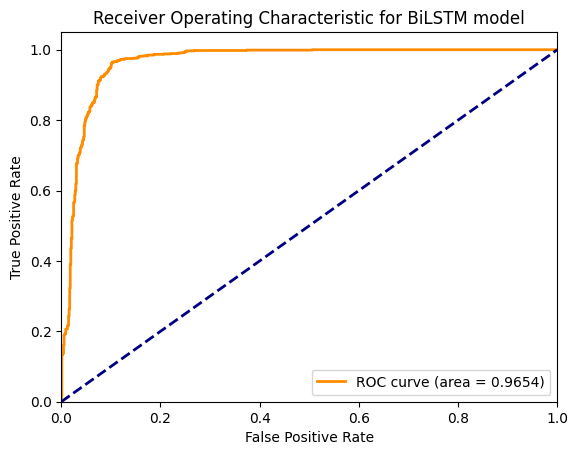

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Define the BiLSTM model
def create_bilstm_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(8, return_sequences=True), input_shape=input_shape),
        Dropout(0.5),
        Bidirectional(LSTM(4)),
        Dropout(0.5),
        Dense(4, activation='relu'),
        Dense(1, activation='sigmoid')  # Use 'sigmoid' for binary classification
    ])
    return model

# Assuming input_shape based on the final_train_df without the target column
input_shape = (1, final_train_df.shape[1] - 1)  # Only one timestep, features equal to number of columns minus target

# Create the model
model = create_bilstm_model(input_shape)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Convert target data to float32 to avoid TypeError
y_train = final_train_df['Wildfire'].astype('float32').values
y_val = final_val_df['Wildfire'].astype('float32').values
y_test = final_test_df['Wildfire'].astype('float32').values

# Reshape data to fit the BiLSTM input requirements: [samples, timesteps, features]
X_train = final_train_df.drop('Wildfire', axis=1).values.reshape(-1, 1, final_train_df.shape[1] - 1)
X_val = final_val_df.drop('Wildfire', axis=1).values.reshape(-1, 1, final_val_df.shape[1] - 1)
X_test = final_test_df.drop('Wildfire', axis=1).values.reshape(-1, 1, final_test_df.shape[1] - 1)

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Predict probabilities for ROC curve
y_pred_probs = model.predict(X_test).ravel()

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for BiLSTM model')
plt.legend(loc="lower right")
plt.show()

In [4]:
def initialize_bwo_population(pop_size, param_bounds):
    population = []
    for _ in range(pop_size):
        spider = {
            'units': np.random.randint(param_bounds['units'][0], param_bounds['units'][1] + 1),
            'dropout': np.random.uniform(param_bounds['dropout'][0], param_bounds['dropout'][1])
        }
        population.append(spider)
    return population


def bwo_crossover_and_cannibalism(population):
    # This is a simplified version. You will need to adapt it based on actual BWO behavior.
    new_population = []
    for spider in population:
        if np.random.rand() < 0.5:  # Random chance to mate
            partner = np.random.choice(population)
            child = {
                'units': int((spider['units'] + partner['units']) / 2),
                'dropout': (spider['dropout'] + partner['dropout']) / 2
            }
            new_population.append(child)
        else:
            new_population.append(spider)
    return new_population


def bwo_select_survivors(population, max_population_size):
    # Sort by fitness and select the top survivors
    sorted_population = sorted(population, key=lambda x: x['fitness'])
    return sorted_population[:max_population_size]


def bwo_optimize_rnn(X_train, y_train, X_val, y_val):
    param_bounds = {'units': (10, 50), 'dropout': (0.1, 0.5)}
    population = initialize_bwo_population(10, param_bounds)
    max_generations = 20

    best_fitness = float('inf')
    best_params = None

    for generation in range(max_generations):
        for spider in population:
            params = {'units': spider['units'], 'dropout': spider['dropout']}
            model = create_rnn_model(params, X_train.shape[2])
            model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
            model.fit(X_train, y_train, epochs=20, verbose=0)
            loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
            spider['fitness'] = loss  # Lower loss is better

            if spider['fitness'] < best_fitness:
                best_fitness = spider['fitness']
                best_params = spider

        population = bwo_crossover_and_cannibalism(population)
        population = bwo_select_survivors(population, 10)

    return best_params


Generation 1/5, Best Fitness: 0.14482568204402924
Generation 2/5, Best Fitness: 0.14482568204402924
Generation 3/5, Best Fitness: 0.14211517572402954
Generation 4/5, Best Fitness: 0.14211517572402954
Generation 5/5, Best Fitness: 0.14211517572402954
Best Parameters: {'units': 25, 'dropout': 0.26872193387649984, 'fitness': 0.14211517572402954}
Epoch 1/20
263/263 [==============================] - 13s 13ms/step - loss: 0.3622 - accuracy: 0.8621 - val_loss: 0.2200 - val_accuracy: 0.9289
Epoch 2/20
263/263 [==============================] - 2s 7ms/step - loss: 0.2243 - accuracy: 0.9192 - val_loss: 0.2043 - val_accuracy: 0.9294
Epoch 3/20
263/263 [==============================] - 2s 7ms/step - loss: 0.2117 - accuracy: 0.9213 - val_loss: 0.1923 - val_accuracy: 0.9333
Epoch 4/20
263/263 [==============================] - 2s 7ms/step - loss: 0.2016 - accuracy: 0.9265 - val_loss: 0.1862 - val_accuracy: 0.9339
Epoch 5/20
263/263 [==============================] - 3s 11ms/step - loss: 0.1890 - a

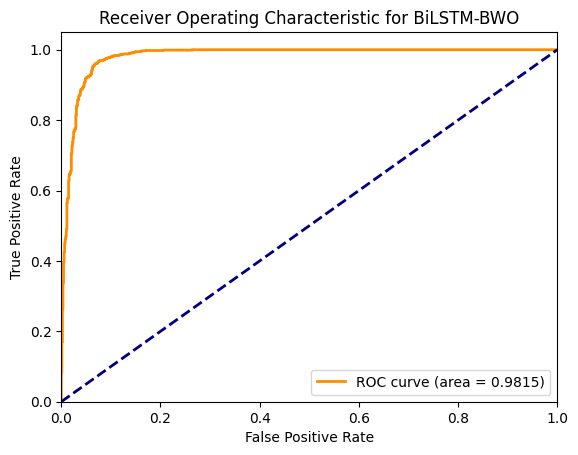

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Define the BiLSTM model creation function
def create_bilstm_model(params, input_feature_count):
    model = Sequential([
        Bidirectional(LSTM(params['units'], return_sequences=True), input_shape=(1, input_feature_count)),
        Dropout(params['dropout']),
        Bidirectional(LSTM(params['units'], return_sequences=False)),
        Dropout(params['dropout']),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

# Initialize BWO population
def initialize_bwo_population(pop_size, param_bounds):
    population = []
    for _ in range(pop_size):
        spider = {
            'units': np.random.randint(param_bounds['units'][0], param_bounds['units'][1] + 1),
            'dropout': np.random.uniform(param_bounds['dropout'][0], param_bounds['dropout'][1]),
            'fitness': None  # Initialize fitness
        }
        population.append(spider)
    return population

# BWO Crossover and Cannibalism
def bwo_crossover_and_cannibalism(population):
    new_population = []
    for spider in population:
        if np.random.rand() < 0.5:  # Random chance to mate
            partner = np.random.choice(population)
            child = {
                'units': int((spider['units'] + partner['units']) / 2),
                'dropout': (spider['dropout'] + partner['dropout']) / 2,
                'fitness': None  # Reset fitness for new child
            }
            new_population.append(child)
        else:
            new_population.append(spider)
    return new_population

# Select survivors based on fitness
def bwo_select_survivors(population, max_population_size):
    # Ensure all spiders have a fitness value
    for spider in population:
        if spider['fitness'] is None:
            spider['fitness'] = float('inf')  # Assign worst fitness if not evaluated
    # Sort by fitness and select the top survivors
    sorted_population = sorted(population, key=lambda x: x['fitness'])
    return sorted_population[:max_population_size]

# Optimize BiLSTM using BWO
def bwo_optimize_bilstm(X_train, y_train, X_val, y_val):
    param_bounds = {'units': (10, 50), 'dropout': (0.1, 0.5)}
    population = initialize_bwo_population(5, param_bounds)
    max_generations = 5

    best_fitness = float('inf')
    best_params = None

    for generation in range(max_generations):
        for spider in population:
            params = {'units': spider['units'], 'dropout': spider['dropout']}
            model = create_bilstm_model(params, X_train.shape[2])
            model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
            model.fit(X_train, y_train, epochs=20, verbose=0)  # Reduced verbosity for optimization
            loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
            spider['fitness'] = loss  # Lower loss is better

            if spider['fitness'] < best_fitness:
                best_fitness = spider['fitness']
                best_params = spider

        population = bwo_crossover_and_cannibalism(population)
        population = bwo_select_survivors(population, 10)
        print(f"Generation {generation+1}/{max_generations}, Best Fitness: {best_fitness}")

    return best_params

# Assuming X_train, X_val, y_train, y_val, X_test, and y_test are already defined
input_feature_count = X_train.shape[2]

# Optimize the BiLSTM using BWO
best_params = bwo_optimize_bilstm(X_train, y_train, X_val, y_val)
print(f"Best Parameters: {best_params}")

# Create the model with optimal parameters
model = create_bilstm_model(best_params, input_feature_count)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predict probabilities for the test set
y_pred_probs = model.predict(X_test).ravel()

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for BiLSTM-BWO')
plt.legend(loc="lower right")
plt.show()


In [7]:
df1 = pd.read_csv('/content/drive/MyDrive/Export_Output1_with_lat_long.csv', names= ['pointid', 'grid_code', 'aspect', 'temp_july', 'soilmois', 'slope', 'ndvi',
                                      'lulc', 'dist_lake', 'elevation', 'dist_road', 'dist_river', 'pcp',
                                      'Latitude', 'Longitude'
                                                   ], header= 0)

In [8]:
col_to_drop = ['pointid', 'grid_code']
df1 = df1.drop(columns= col_to_drop, axis= 1)

In [9]:
# Assuming your dataframe is named df1
df1.replace(-9999, np.nan, inplace=True)

# To check if the replacement worked and see the count of null values in each column
null_counts = df1.isnull().sum()
print(null_counts)


aspect          0
temp_july       0
soilmois      509
slope           0
ndvi          514
lulc            0
dist_lake       0
elevation       0
dist_road      76
dist_river     77
pcp           510
Latitude        0
Longitude       0
dtype: int64


In [10]:
from sklearn.neighbors import KNeighborsClassifier

# Assuming your dataframe is named df1
# Separate the rows with and without missing values
df_missing = df1[df1.isnull().any(axis=1)]
df_not_missing = df1.dropna()

# Define the features (latitude and longitude) and target
features = ['Latitude', 'Longitude']
target_columns = df1.columns[df1.isnull().any()].tolist()  # Columns with missing values

# For each target column with missing values, we will use KNN to impute the values
for target in target_columns:
    # Prepare the training data
    X_train = df_not_missing[features]
    y_train = df_not_missing[target]

    # Prepare the data to be imputed
    X_missing = df_missing[features]

    # Initialize and fit the KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=3)  # Using 3 nearest neighbors, you can adjust this number
    knn.fit(X_train, y_train)

    # Predict the missing values
    imputed_values = knn.predict(X_missing)

    # Fill the missing values in the original dataframe
    df1.loc[df_missing.index, target] = imputed_values

# Check again for any remaining null values
null_counts_after_imputation = df1.isnull().sum()
print(null_counts_after_imputation)


aspect        0
temp_july     0
soilmois      0
slope         0
ndvi          0
lulc          0
dist_lake     0
elevation     0
dist_road     0
dist_river    0
pcp           0
Latitude      0
Longitude     0
dtype: int64


In [11]:
df1 = df1.astype(
    {
        'aspect': 'category',
        'temp_july': 'category',
        'soilmois': 'category',
        'slope': 'category',
        'ndvi': 'category',
        'lulc': 'category',
        'dist_lake': 'category',
        'elevation': 'category',
        'dist_road': 'category',
        'dist_river': 'category',
        'pcp': 'category'
    }
)

In [12]:
df1.head()

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude
0,4,4,4.0,2,5.0,4,1,2,1.0,2.0,3.0,45.478238,-80.333373
1,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.474184,-80.308844
2,4,4,4.0,2,5.0,4,1,2,1.0,3.0,3.0,45.470122,-80.284320
3,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.466055,-80.259800
4,5,4,4.0,2,5.0,4,1,2,0.0,3.0,3.0,45.461980,-80.235285


In [13]:
col_to_drop = ['Latitude', 'Longitude']
df1_new = df1.drop(columns= col_to_drop, axis= 1)

In [14]:
df1.shape

(1000001, 13)

In [15]:
df1_new.shape

(1000001, 11)

In [16]:
from sklearn.preprocessing import OneHotEncoder

# Use the trained encoder to transform the categorical data
encoded_data_new = encoder.transform(df1_new[categorical_columns])

# Convert the encoded data to DataFrame
encoded_df_new = pd.DataFrame(encoded_data_new, columns=encoder.get_feature_names_out())

# Concatenate the encoded DataFrame with the non-categorical data
final_df_new = pd.concat([df1_new.drop(categorical_columns, axis=1), encoded_df_new], axis=1)

# Ensure to drop any columns that are not used by the model
# final_df_new.drop(['Latitude', 'Longitude', 'pointid', 'grid_code'], axis=1, inplace=True)

# Reshape data to fit RNN input requirements
X_new = final_df_new.values.reshape(-1, 1, final_df_new.shape[1])

# Load your trained RNN model (if not already loaded)

# Predict using RNN model
predictions = model.predict(X_new)

predictions_df = pd.DataFrame(predictions, columns=['WF_BiLSTM_BWO']).round(3)

# Display the last 10 entries
predictions_df.tail(10)



31251/31251 [==============================] - 102s 3ms/step


,WF_BiLSTM_BWO
999991,0.776
999992,0.670
999993,0.670
999994,0.672
999995,0.656
999996,0.716
999997,0.816
999998,0.893
999999,0.870
1000000,0.842


In [17]:
# Ensure the predictions DataFrame is properly aligned with the original DataFrame
df1['WF_BiLSTM_BWO'] = predictions_df['WF_BiLSTM_BWO'].values

In [23]:
df1.tail(50)

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude,WF_BiLSTM_BWO
999951,3,2,1.0,5,3.0,4,3,3,3.0,4.0,3.0,52.195999,-67.078723,0.556
999952,2,2,1.0,3,3.0,4,3,3,3.0,4.0,3.0,52.188270,-67.051953,0.881
999953,5,2,1.0,2,3.0,4,3,3,3.0,4.0,3.0,52.180534,-67.025194,0.842
999954,2,2,1.0,3,3.0,4,3,3,3.0,4.0,3.0,52.172792,-66.998446,0.881
999955,5,2,1.0,4,4.0,4,3,3,3.0,4.0,3.0,52.165043,-66.971708,0.863
999956,3,2,1.0,4,3.0,4,3,3,3.0,4.0,3.0,52.157287,-66.944980,0.575
999957,3,2,1.0,2,3.0,4,3,3,3.0,4.0,3.0,52.149525,-66.918264,0.716
999958,5,2,1.0,3,3.0,4,3,3,3.0,4.0,3.0,52.141756,-66.891558,0.893
999959,4,2,1.0,3,3.0,4,3,3,3.0,4.0,3.0,52.133980,-66.864862,0.870
999960,3,2,1.0,3,3.0,4,3,3,3.0,4.0,3.0,52.126198,-66.838177,0.794


# Predict the Probability for the Export output 2 csv Using BiLSTM-BWO model

In [24]:
df2 = pd.read_csv('/content/drive/MyDrive/Export_Output_2_with_lat_long.csv', names= ['pointid', 'grid_code', 'aspect', 'temp_july', 'soilmois', 'slope', 'ndvi',
                                      'lulc', 'dist_lake', 'elevation', 'dist_road', 'dist_river', 'pcp',
                                      'Latitude', 'Longitude'
                                                   ], header= 0)

In [25]:
col_to_drop = ['pointid', 'grid_code']
df2 = df2.drop(columns= col_to_drop, axis= 1)

In [26]:
# Assuming your dataframe is named df1
df2.replace(-9999, np.nan, inplace=True)

# To check if the replacement worked and see the count of null values in each column
null_counts = df2.isnull().sum()
print(null_counts)


aspect          0
temp_july       0
soilmois      879
slope           0
ndvi          859
lulc            0
dist_lake       0
elevation       0
dist_road     124
dist_river    124
pcp           881
Latitude        0
Longitude       0
dtype: int64


In [27]:
from sklearn.neighbors import KNeighborsClassifier

# Assuming your dataframe is named df1
# Separate the rows with and without missing values
df_missing = df2[df2.isnull().any(axis=1)]
df_not_missing = df2.dropna()

# Define the features (latitude and longitude) and target
features = ['Latitude', 'Longitude']
target_columns = df2.columns[df2.isnull().any()].tolist()  # Columns with missing values

# For each target column with missing values, we will use KNN to impute the values
for target in target_columns:
    # Prepare the training data
    X_train = df_not_missing[features]
    y_train = df_not_missing[target]

    # Prepare the data to be imputed
    X_missing = df_missing[features]

    # Initialize and fit the KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=3)  # Using 3 nearest neighbors, you can adjust this number
    knn.fit(X_train, y_train)

    # Predict the missing values
    imputed_values = knn.predict(X_missing)

    # Fill the missing values in the original dataframe
    df2.loc[df_missing.index, target] = imputed_values

# Check again for any remaining null values
null_counts_after_imputation = df2.isnull().sum()
print(null_counts_after_imputation)


aspect        0
temp_july     0
soilmois      0
slope         0
ndvi          0
lulc          0
dist_lake     0
elevation     0
dist_road     0
dist_river    0
pcp           0
Latitude      0
Longitude     0
dtype: int64


In [28]:
df2 = df2.astype(
    {
        'aspect': 'category',
        'temp_july': 'category',
        'soilmois': 'category',
        'slope': 'category',
        'ndvi': 'category',
        'lulc': 'category',
        'dist_lake': 'category',
        'elevation': 'category',
        'dist_road': 'category',
        'dist_river': 'category',
        'pcp': 'category'
    }
)

In [29]:
col_to_drop = ['Latitude', 'Longitude']
df2_new = df2.drop(columns= col_to_drop, axis= 1)

In [30]:
from sklearn.preprocessing import OneHotEncoder

# Use the trained encoder to transform the categorical data
encoded_data_new2 = encoder.transform(df2_new[categorical_columns])

# Convert the encoded data to DataFrame
encoded_df_new2 = pd.DataFrame(encoded_data_new2, columns=encoder.get_feature_names_out())

# Concatenate the encoded DataFrame with the non-categorical data
final_df_new2 = pd.concat([df2_new.drop(categorical_columns, axis=1), encoded_df_new2], axis=1)

# Ensure to drop any columns that are not used by the model
# final_df_new.drop(['Latitude', 'Longitude', 'pointid', 'grid_code'], axis=1, inplace=True)

# Reshape data to fit RNN input requirements
X_new2 = final_df_new2.values.reshape(-1, 1, final_df_new2.shape[1])


# Predict using BiLSTM model
predictions = model.predict(X_new2)

# Optionally, convert predictions to a DataFrame or other format as needed
predictions_df2 = pd.DataFrame(predictions, columns=['WF_BiLSTM_BWO'])

# Round the predictions to 2 decimal places
predictions_df2['WF_BiLSTM_BWO'] = predictions_df2['WF_BiLSTM_BWO'].round(3)

# Display the last 10 entries
predictions_df2.tail(10)



31785/31785 [==============================] - 116s 4ms/step


,WF_BiLSTM_BWO
1017092,0.0
1017093,0.0
1017094,0.0
1017095,0.0
1017096,0.0
1017097,0.0
1017098,0.0
1017099,0.0
1017100,0.0
1017101,0.0


In [31]:
# Ensure the predictions DataFrame is properly aligned with the original DataFrame
df2['WF_BiLSTM_BWO'] = predictions_df2['WF_BiLSTM_BWO'].values

In [37]:
df2.head(10)

,aspect,temp_july,soilmois,slope,ndvi,lulc,dist_lake,elevation,dist_road,dist_river,pcp,Latitude,Longitude,WF_BiLSTM_BWO
0,3,2,1.0,4,3.0,4,3,3,3.0,4.0,2.0,51.801392,-65.753268,0.812
1,2,2,1.0,2,3.0,4,3,3,3.0,4.0,3.0,51.793332,-65.727031,0.847
2,3,2,1.0,4,3.0,5,3,3,3.0,4.0,3.0,51.785265,-65.700805,0.511
3,4,2,1.0,3,3.0,5,3,3,3.0,4.0,3.0,51.777192,-65.674590,0.803
4,5,2,1.0,2,3.0,4,3,3,3.0,4.0,3.0,51.769113,-65.648385,0.842
5,2,2,1.0,2,3.0,4,3,3,3.0,4.0,3.0,51.761026,-65.622192,0.847
6,2,2,1.0,3,3.0,4,3,3,3.0,4.0,3.0,51.752934,-65.596008,0.881
7,2,2,1.0,3,3.0,4,3,3,3.0,4.0,3.0,51.744834,-65.569836,0.881
8,2,2,1.0,3,3.0,5,3,3,3.0,4.0,3.0,51.736729,-65.543675,0.804
9,5,2,1.0,3,3.0,4,3,3,3.0,4.0,3.0,51.728617,-65.517524,0.893


In [38]:
col_to_drop = ['aspect', 'temp_july', 'soilmois', 'slope',
               'slope', 'ndvi', 'lulc', 'dist_lake', 'elevation',
               'dist_road', 'dist_river', 'pcp', 'Latitude', 'Longitude']
df1_final = df1.drop(columns= col_to_drop, axis= 1)

In [39]:
col_to_drop = ['aspect', 'temp_july', 'soilmois', 'slope',
               'slope', 'ndvi', 'lulc', 'dist_lake', 'elevation',
               'dist_road', 'dist_river', 'pcp', 'Latitude', 'Longitude']
df2_final = df2.drop(columns= col_to_drop, axis= 1)

In [40]:
# Add an 'id' column starting from 0 to the length of the DataFrame minus one
df1_final['FID'] = range(0, len(df1_final))
df2_final['FID'] = range(0, len(df2_final))

In [41]:
df1_final.to_csv('WF_Export1_BiLSTM_BWO.csv', index=False)

In [42]:
df2_final.to_csv('WF_Export2_BiLSTM_BWO.csv', index=False)